# FlowMixer: Implementation Notebook - TENSORFLOW
# 2D fluid flow around a cylinder using the Navier-Stokes equations
### A Neural Architecture for Cross-Domain Time Series Forecasting and Dynamical Systems Prediction

This notebook provides the implementation of "FlowMixer Neural Architecture for Versatile Long Horizon Time Series Forecasting and Dynamical Systems Predictions").

## Overview

FlowMixer represents a significant advance in unifying time series forecasting and dynamical system prediction through a novel neural architecture. This notebook demonstrates the practical implementation of:

1. **Core Architecture Components**:
   - Reversible Instance Normalization (RevIN)
   - Non-negative matrix mixing layers
   - Adaptive skip connections
   - Time and feature mixing modules

2. **Key Applications**:
   - Long-horizon time series forecasting
   - Chaotic system prediction
   - 2D turbulent flow simulation
   - Vorticity field prediction

## Implementation Structure

The notebook is organized into several key sections:

1. **Data Processing**:
   - Custom data loader for time series
   - Spatial vectorization/devectorization utilities
   - Up/downsampling functions for flow data

2. **Model Architecture**:
   - RevNorm layer implementation
   - Noise injection module
   - MixingModule for time-feature interactions
   - Complete FlowMixer model

3. **Training and Evaluation**:
   - Model configuration and training setup
   - Visualization utilities
   - Performance evaluation metrics

## Requirements

- TensorFlow 2.x
- CuPy (for GPU acceleration)
- NumPy
- Matplotlib
- Pandas



## Notes

- The implementation focuses on reproducibility and clarity
- GPU acceleration is utilized where possible for computational efficiency
- Hyperparameters can be adjusted based on specific use cases
- The code is structured to facilitate experimentation with different configurations



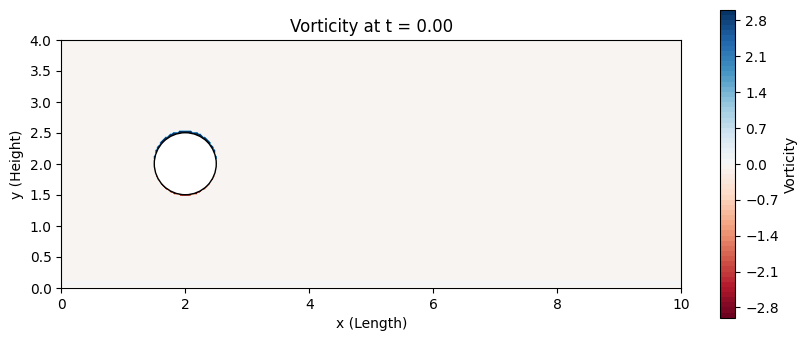

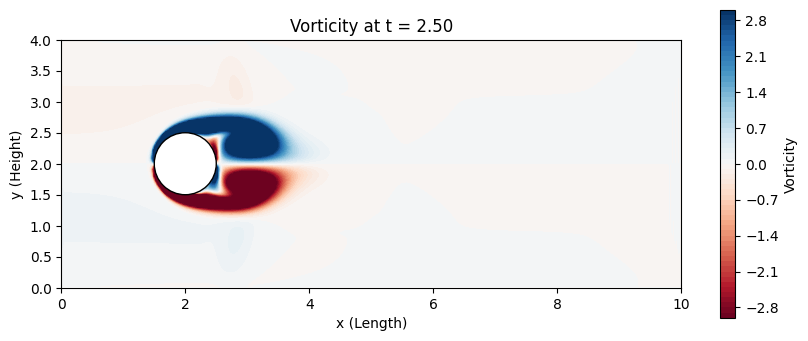

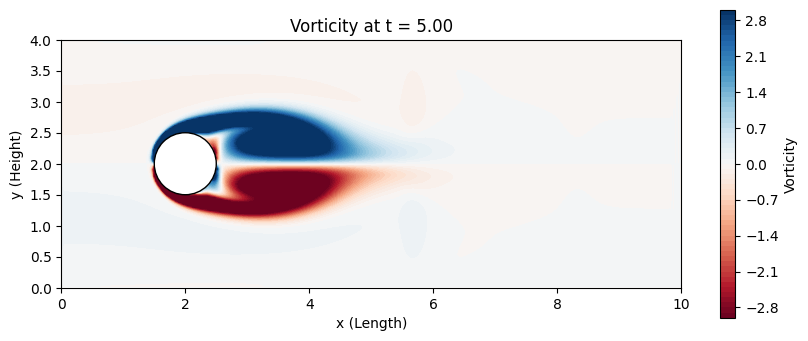

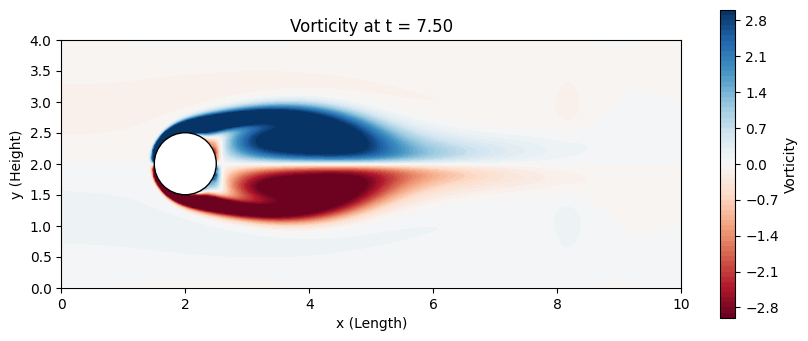

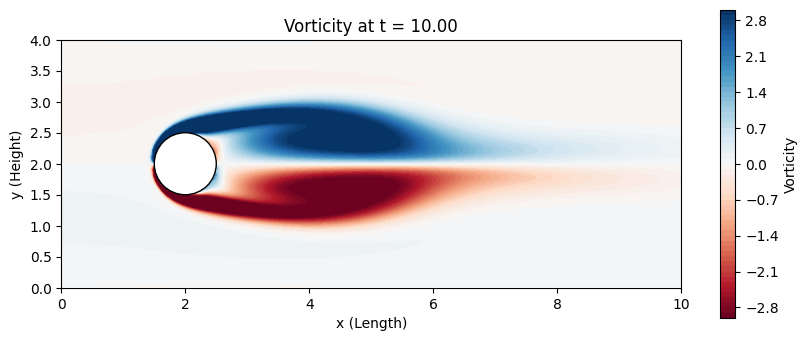

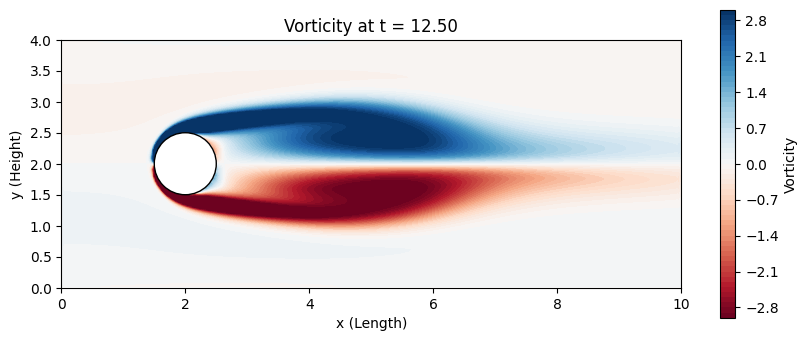

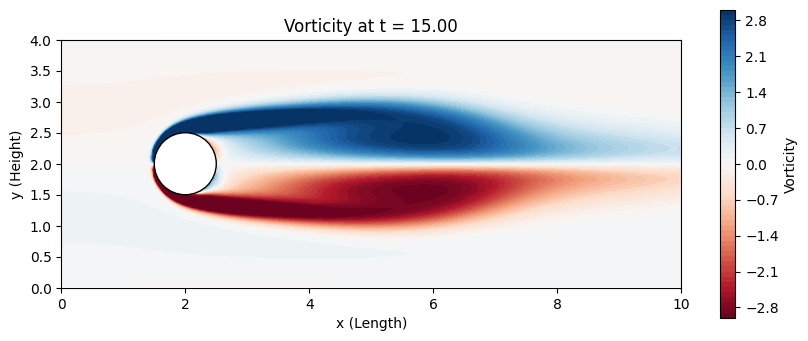

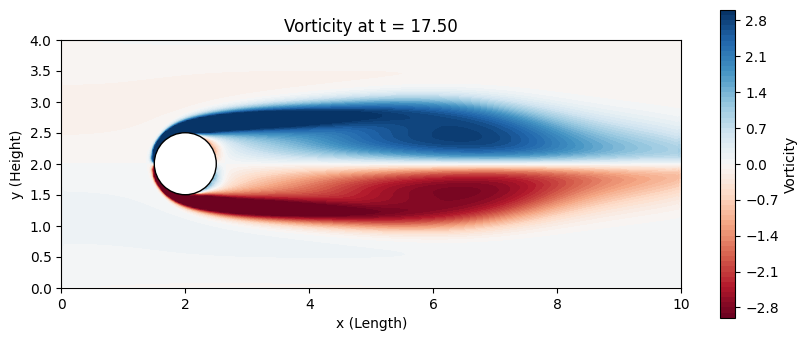

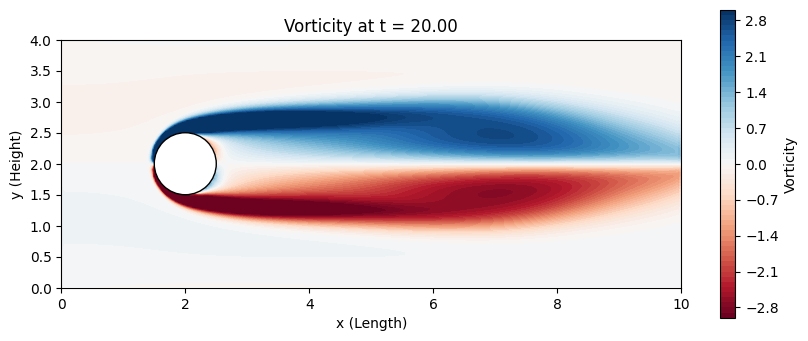

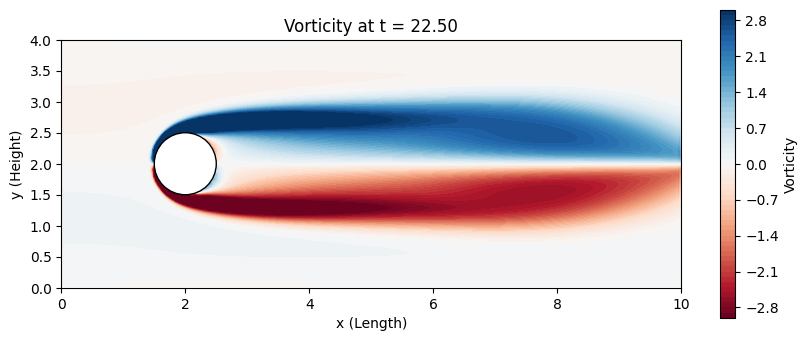

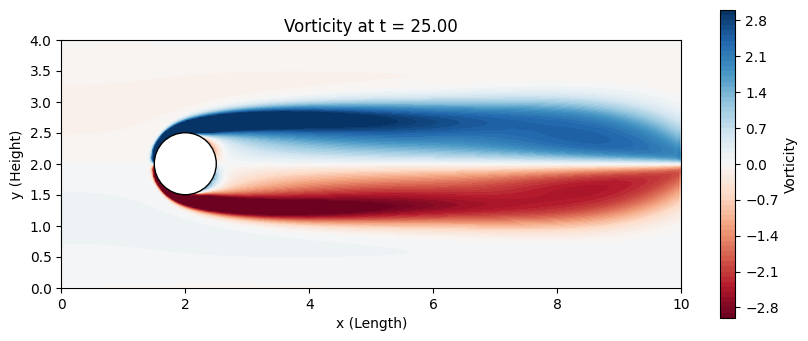

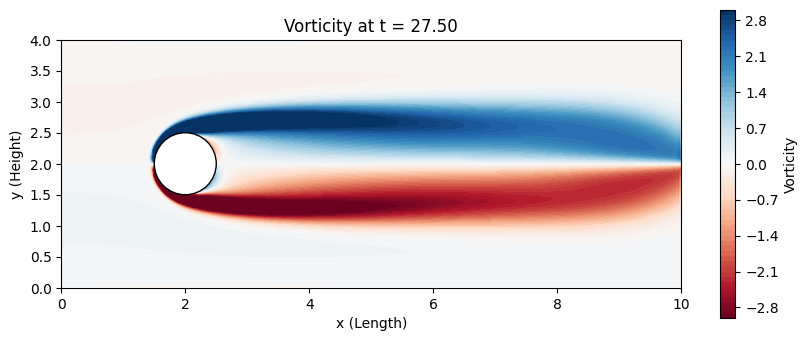

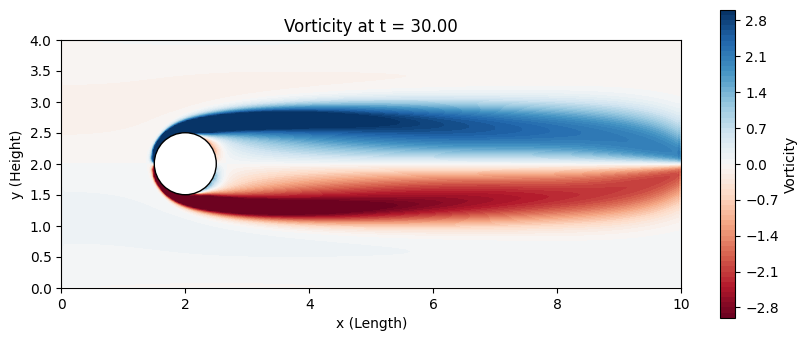

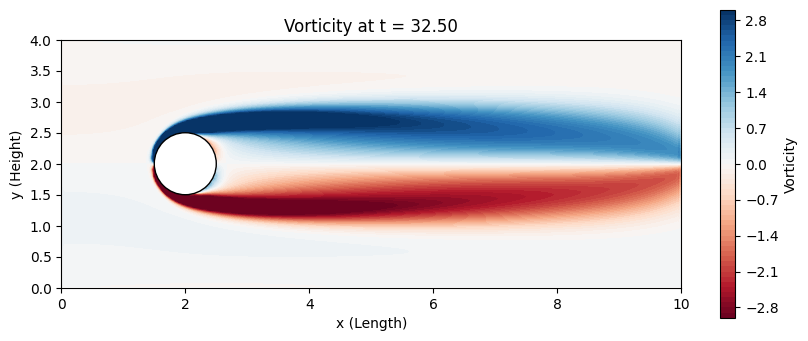

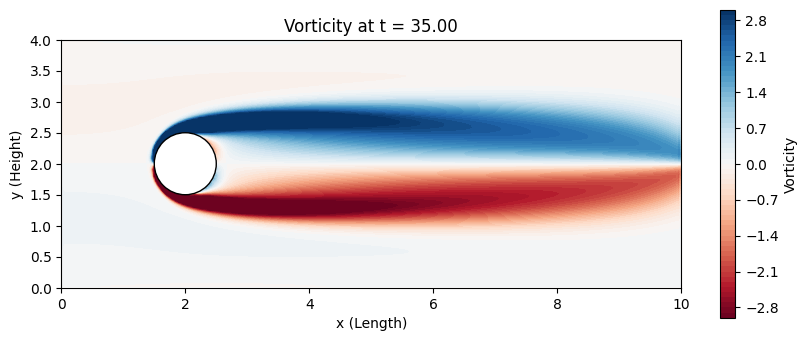

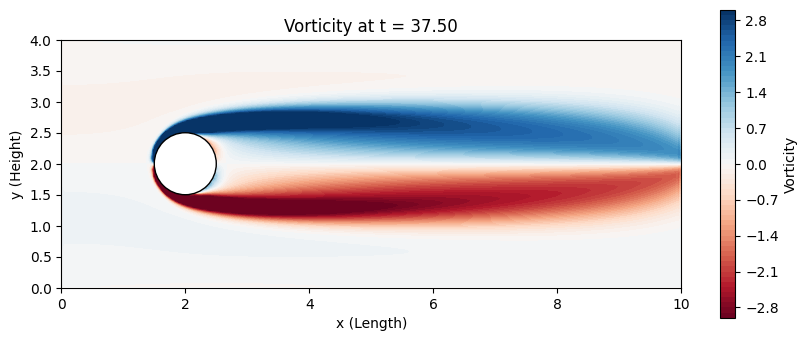

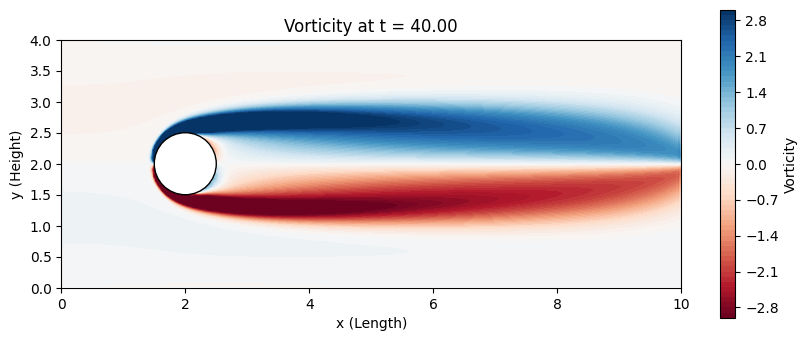

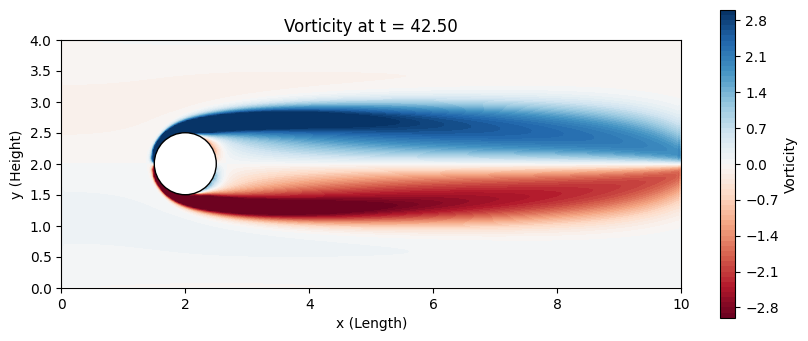

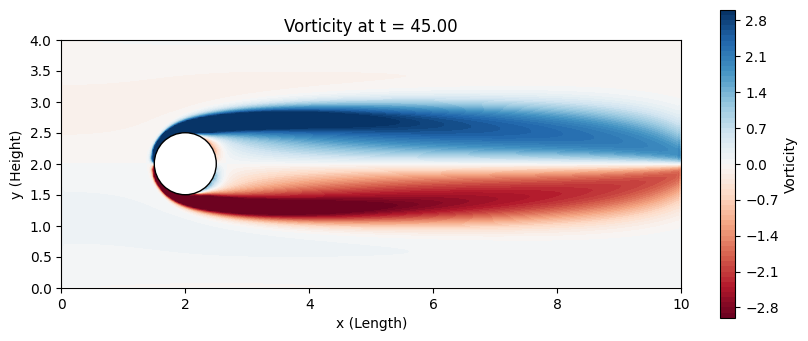

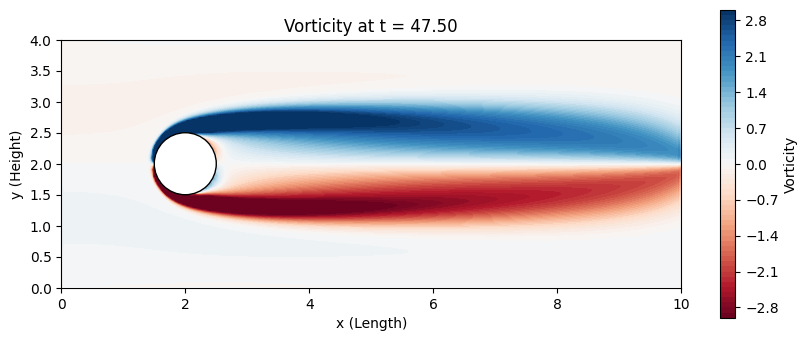

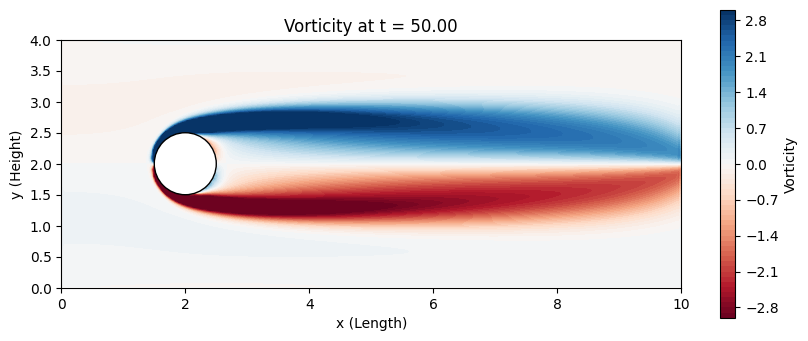

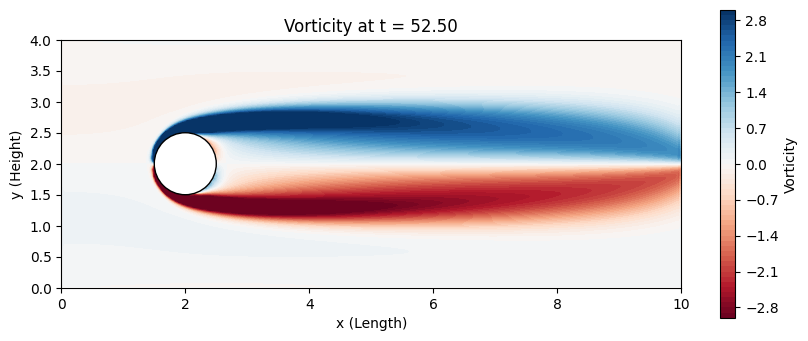

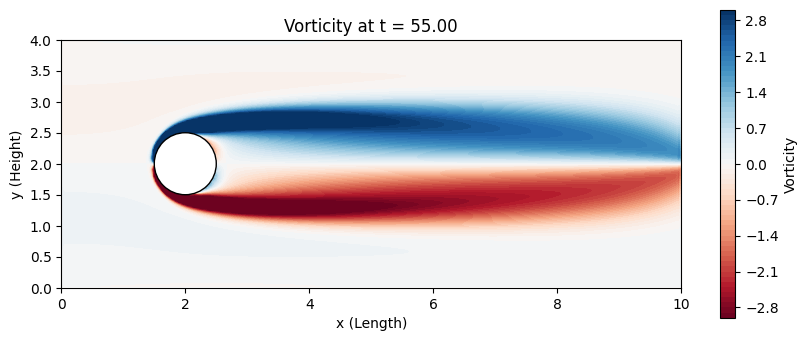

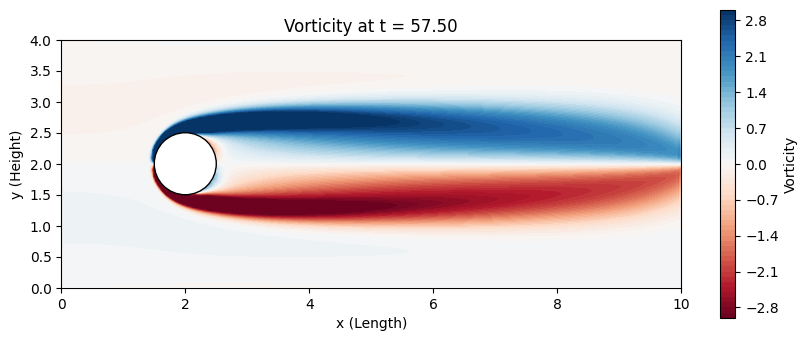

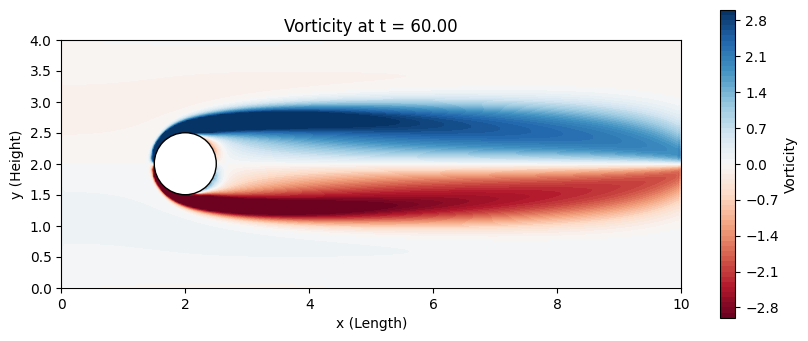

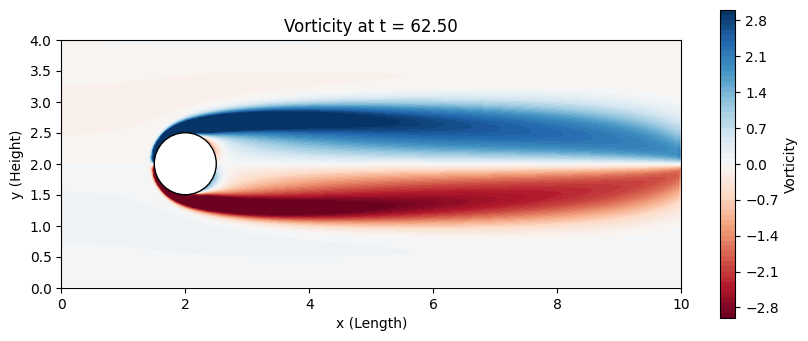

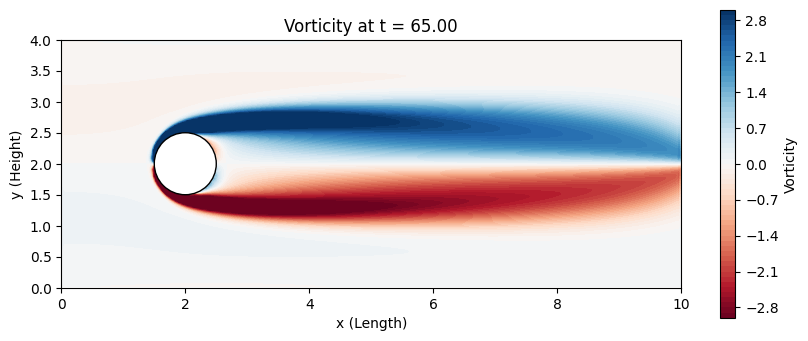

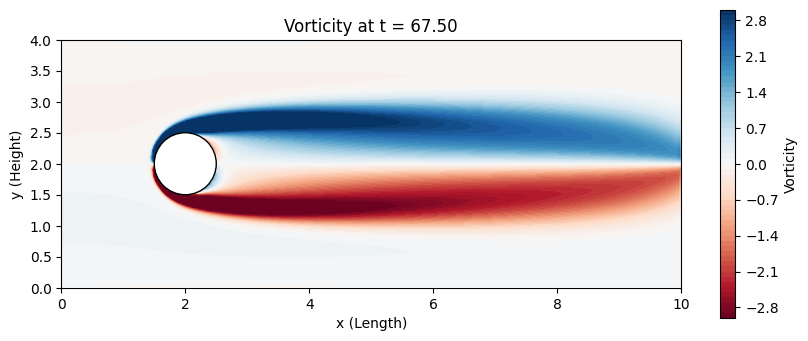

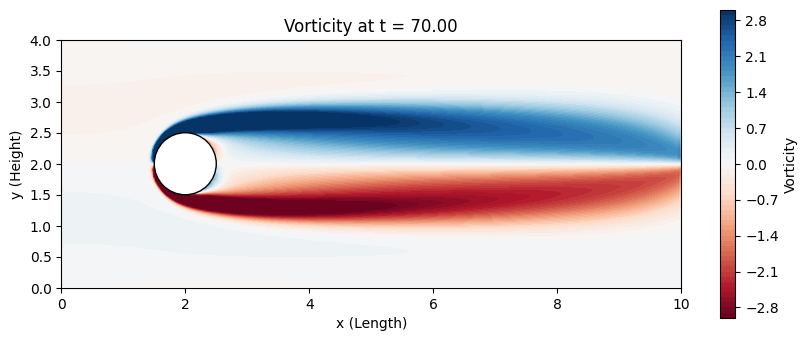

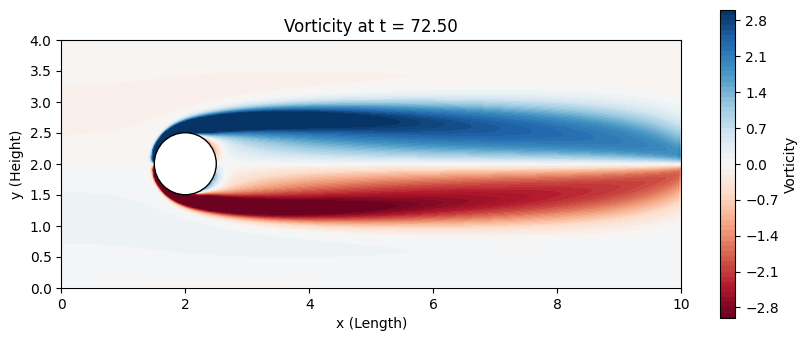

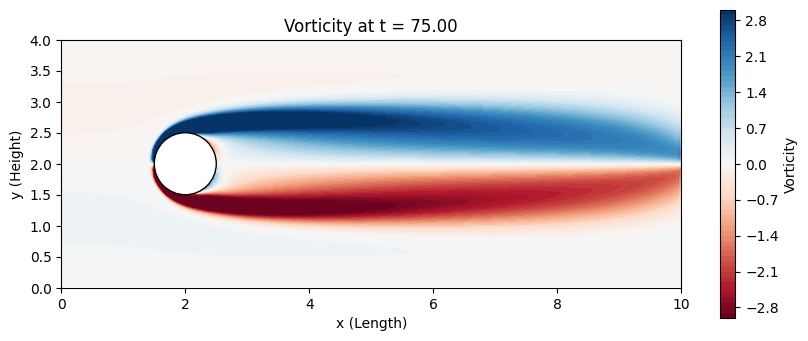

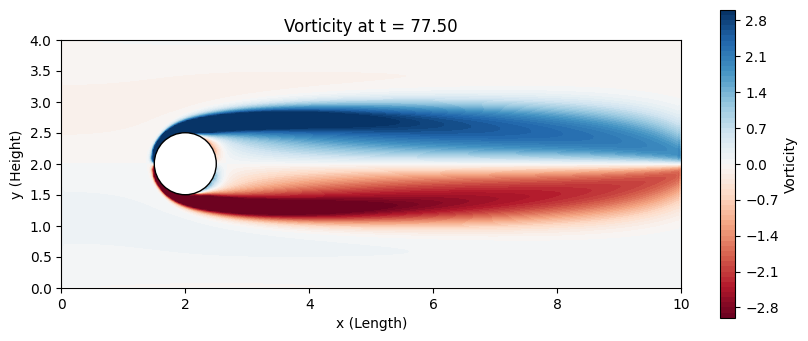

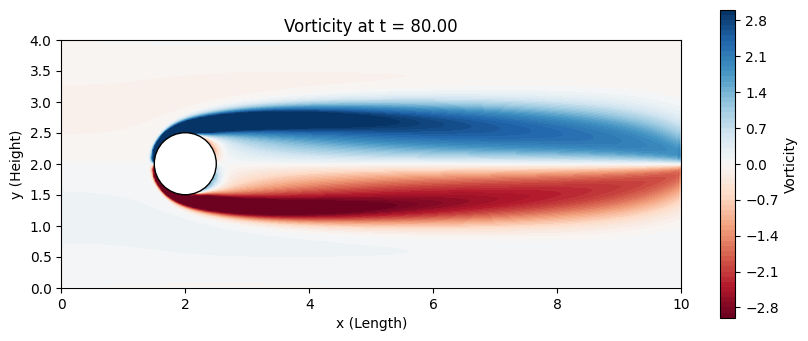

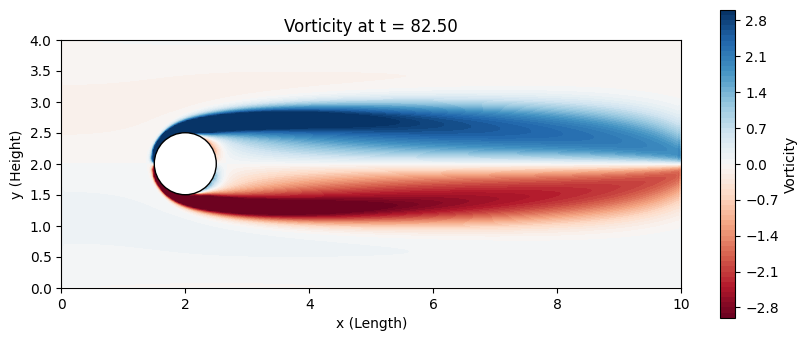

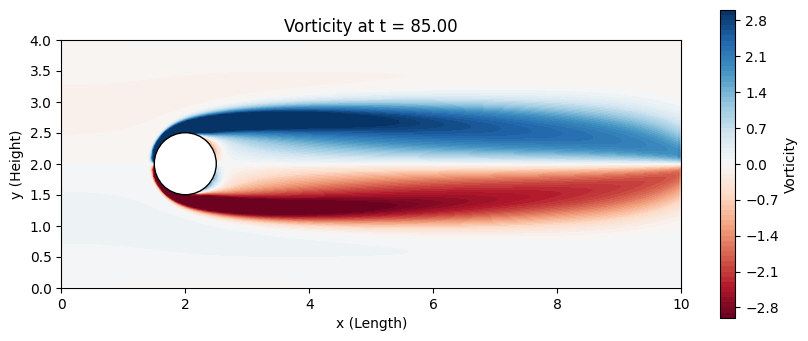

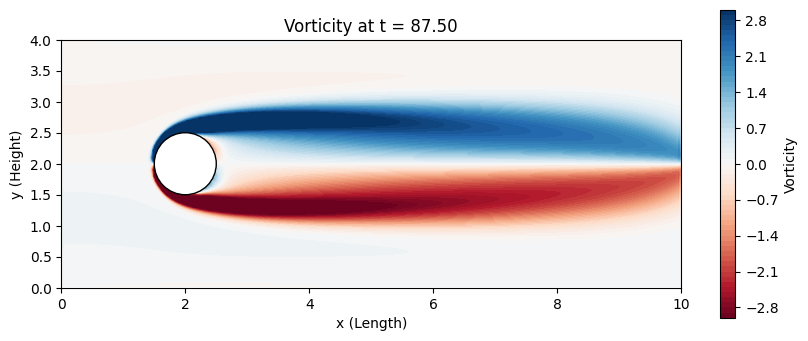

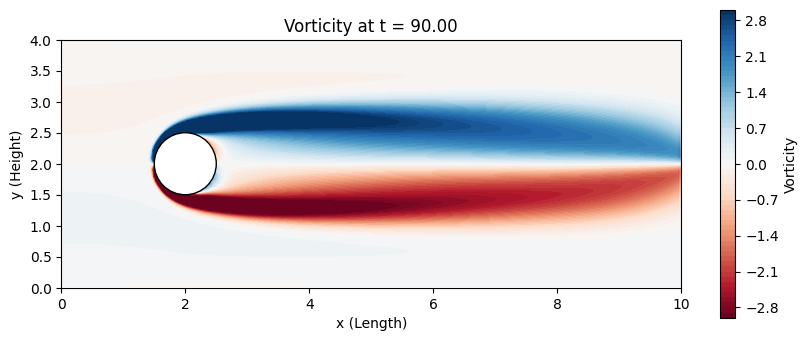

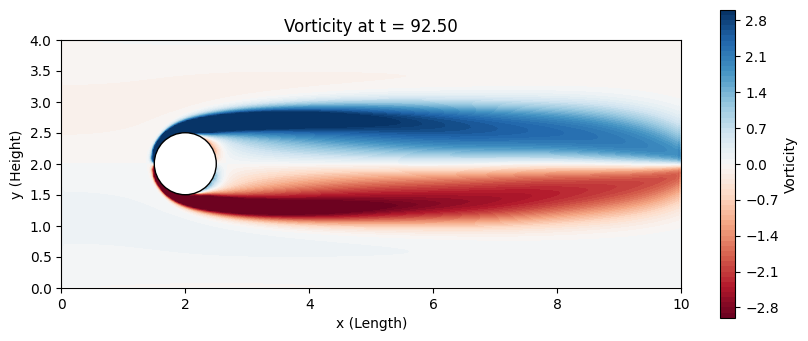

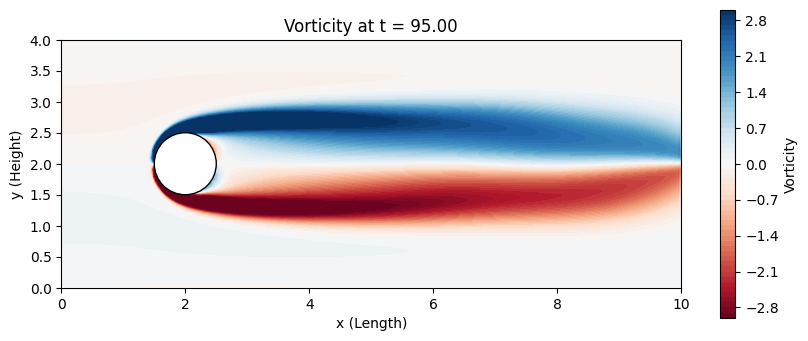

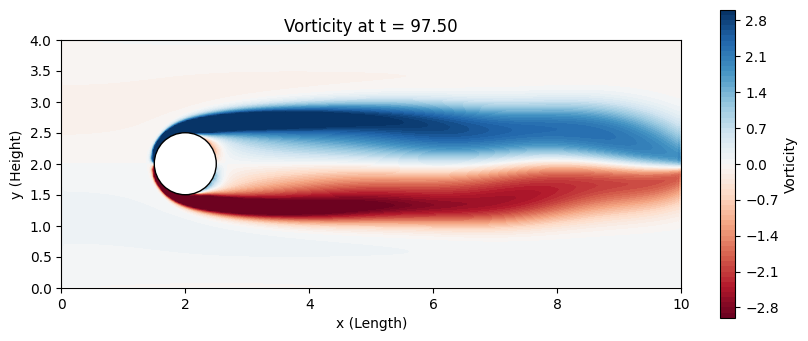

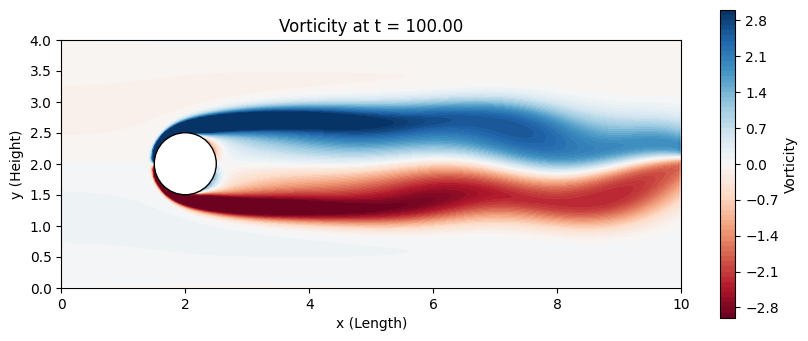

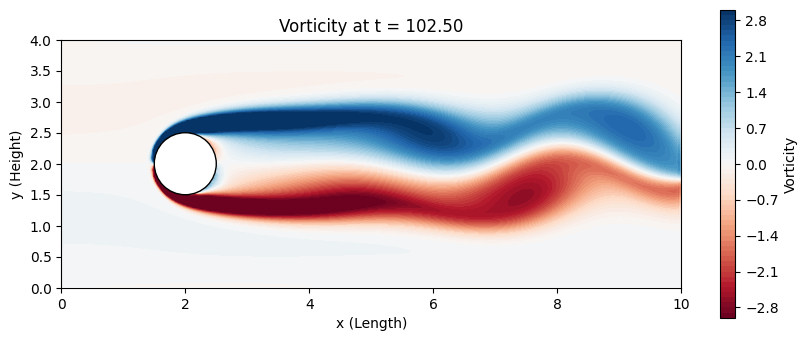

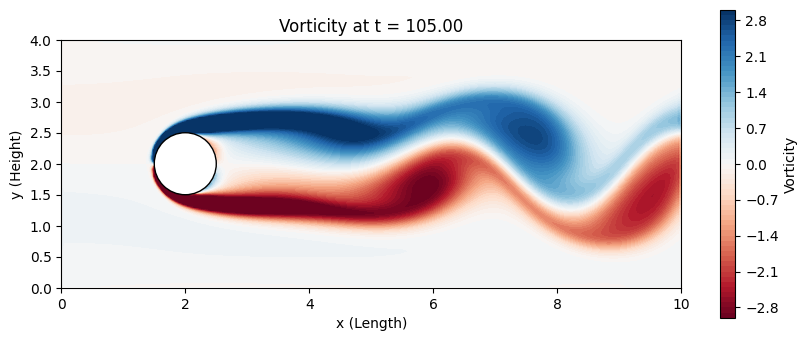

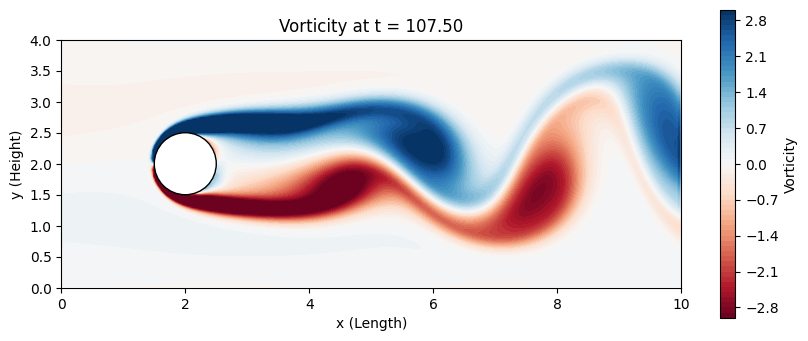

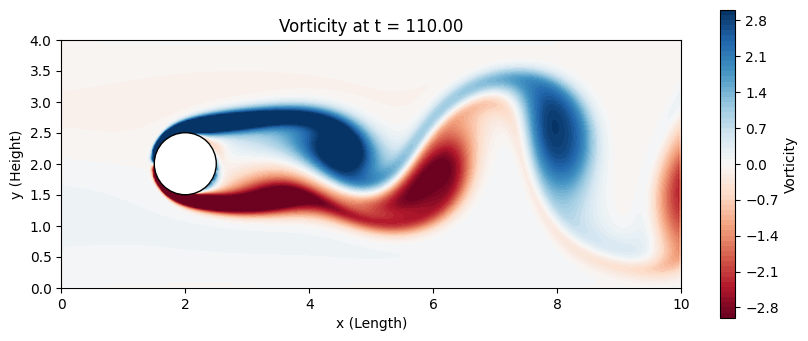

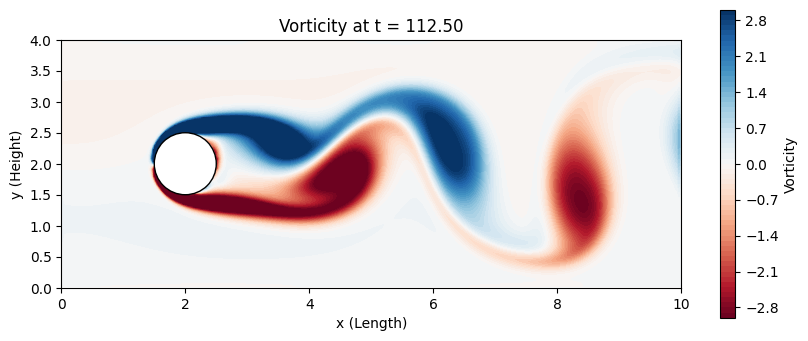

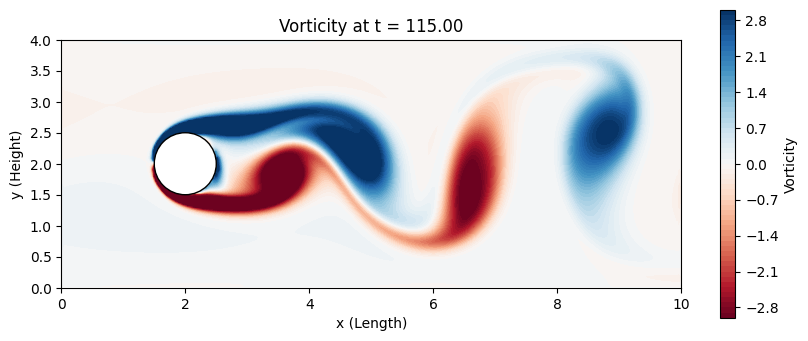

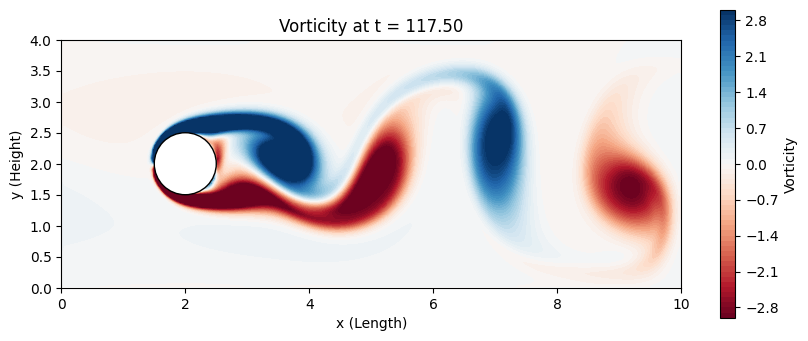

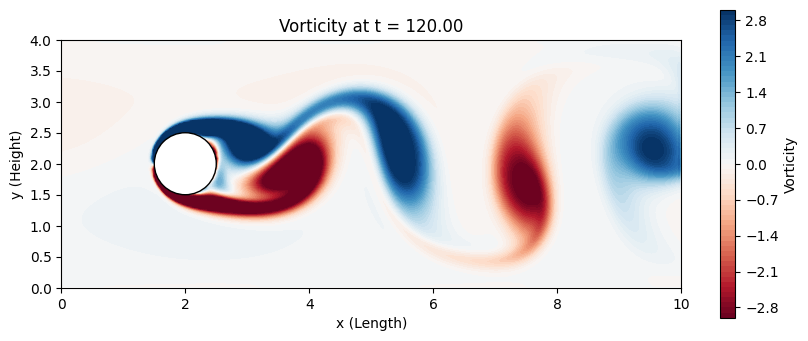

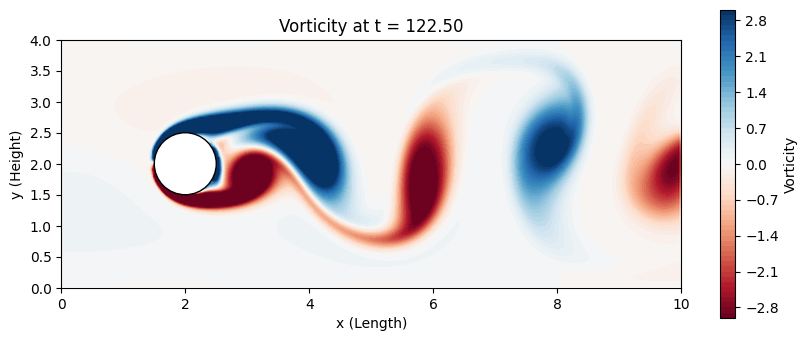

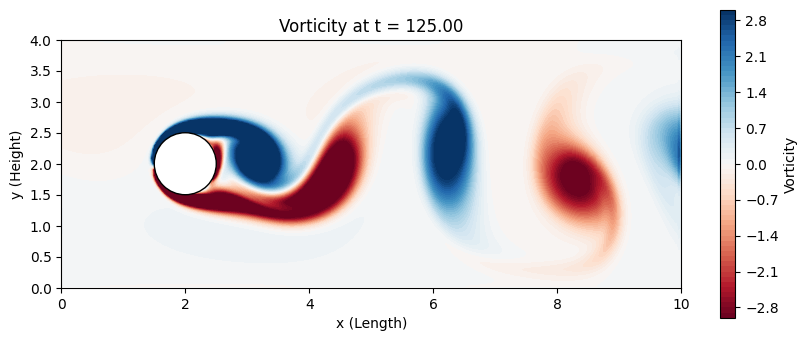

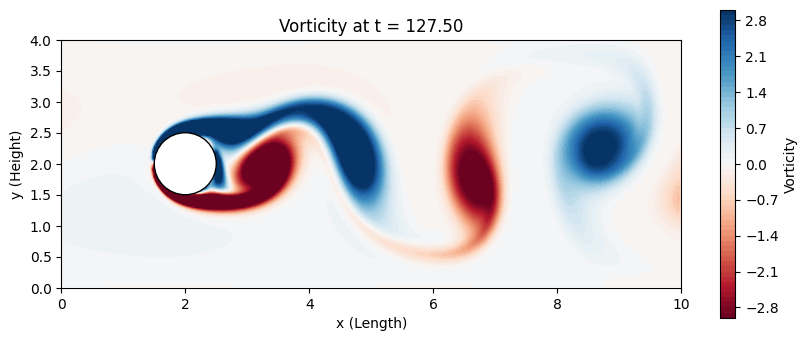

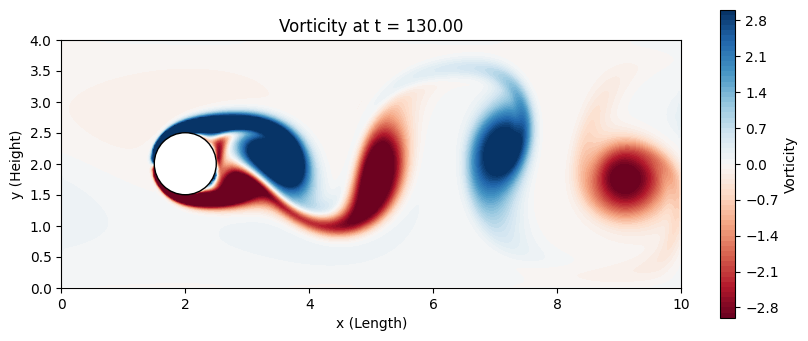

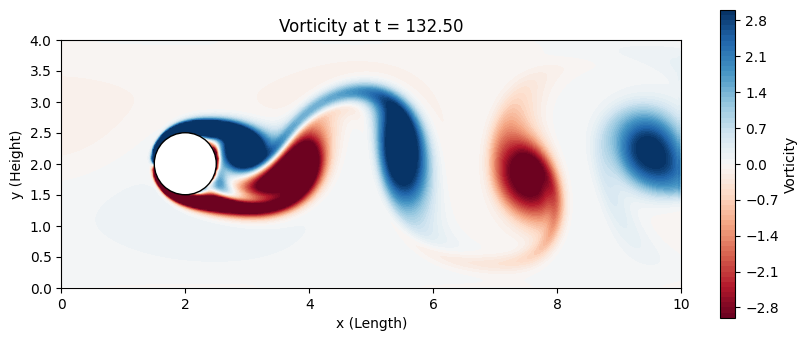

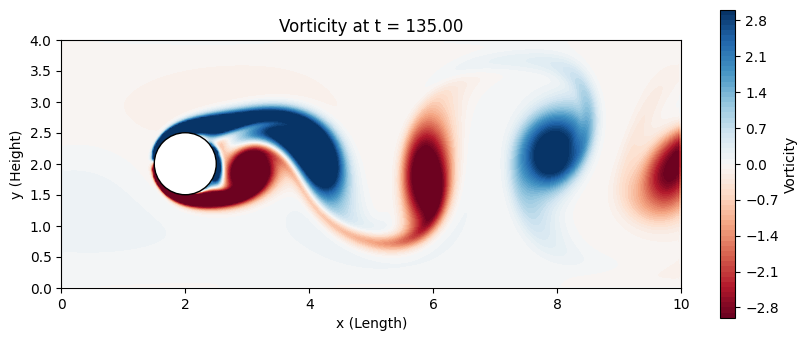

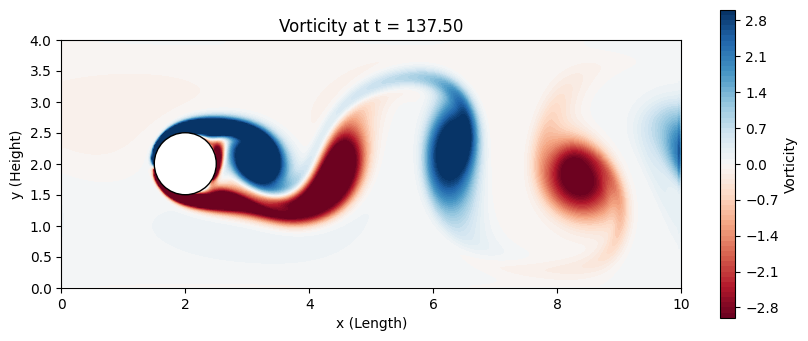

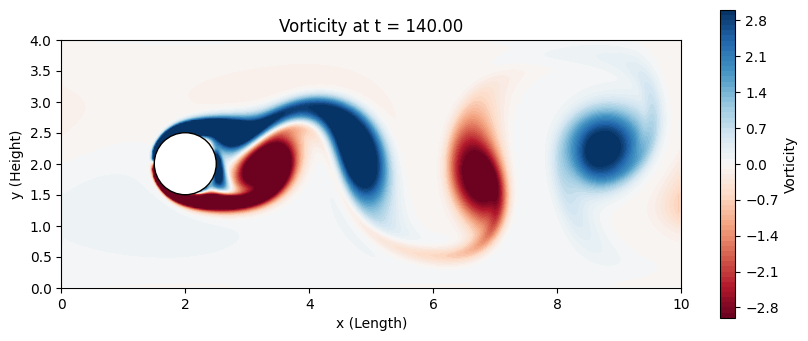

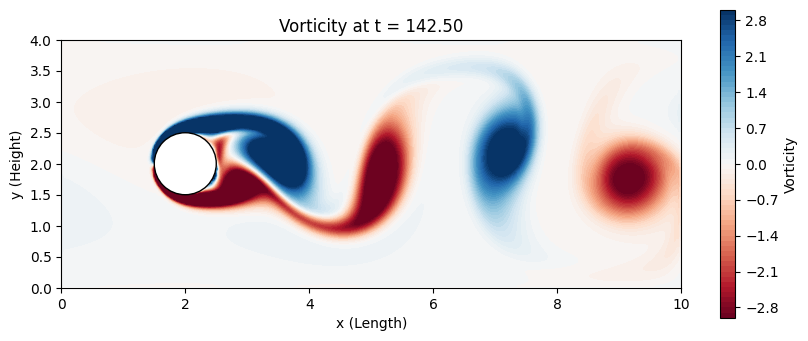

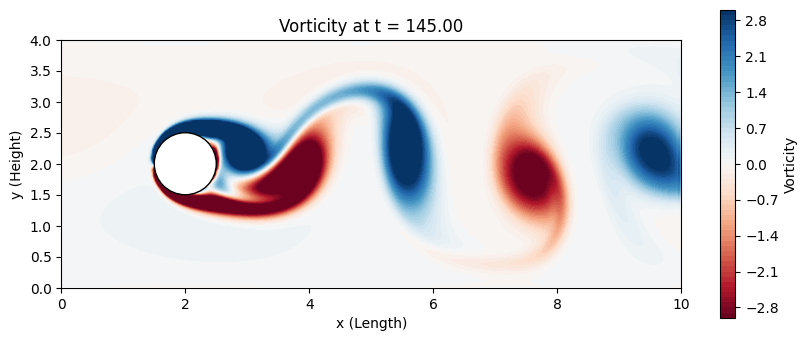

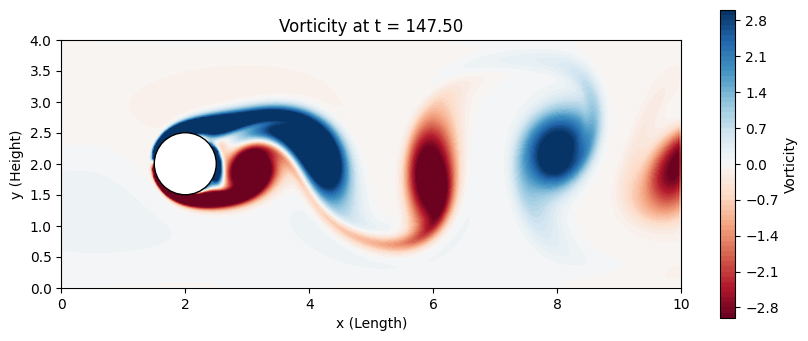

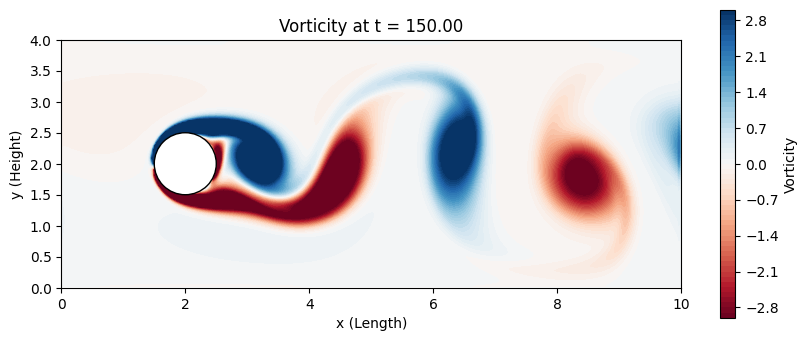

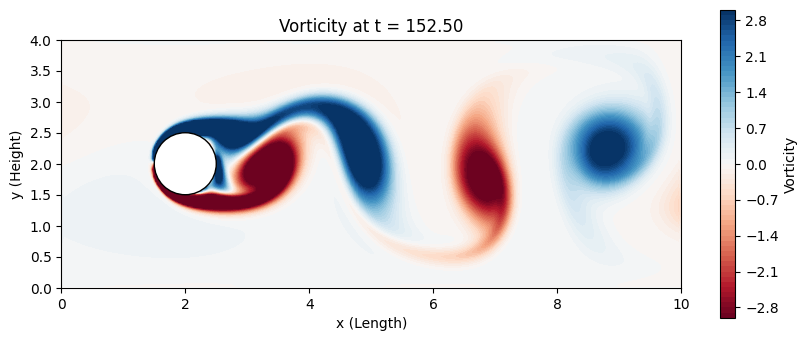

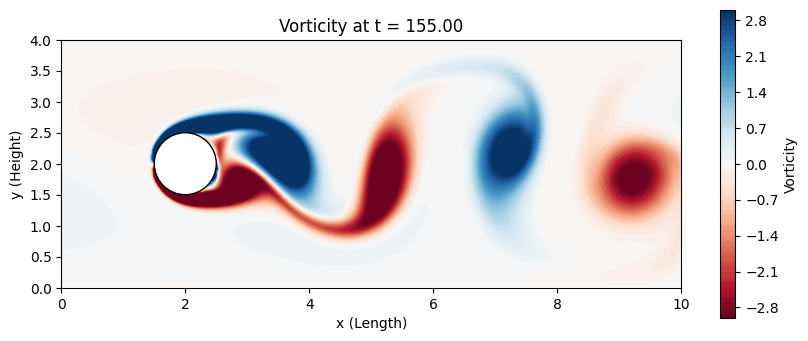

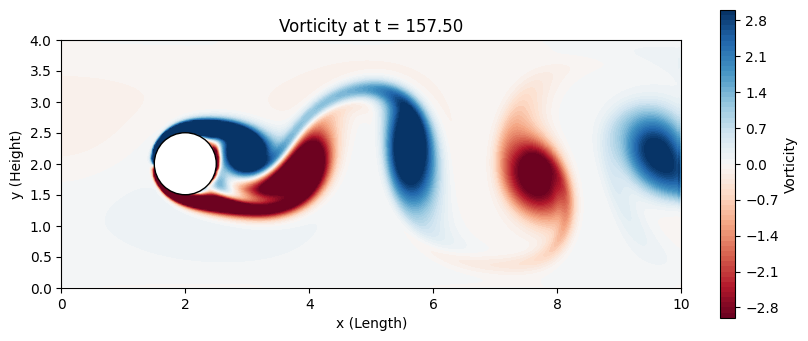

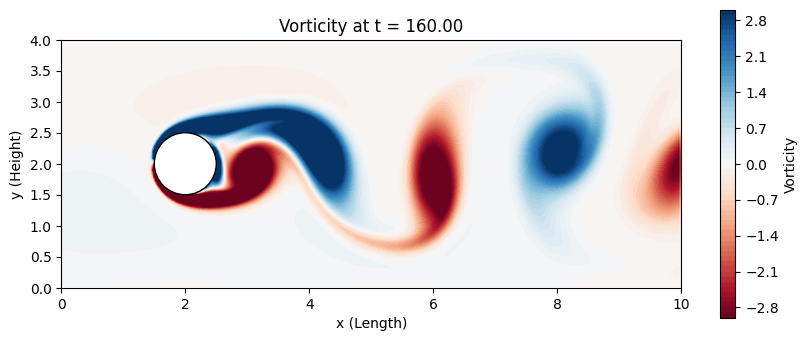

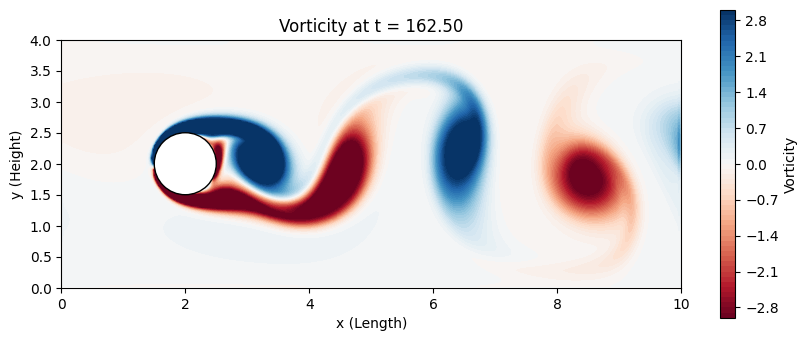

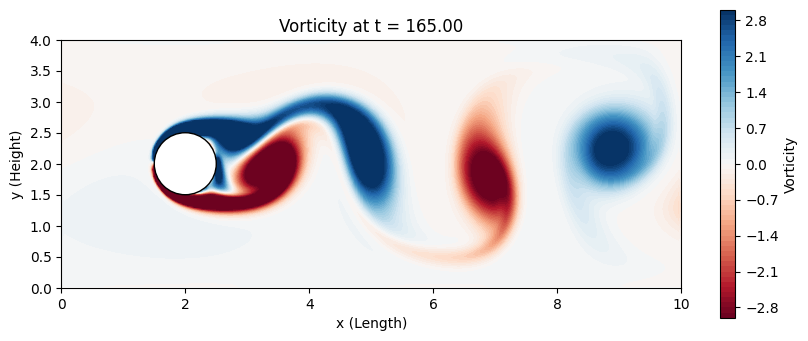

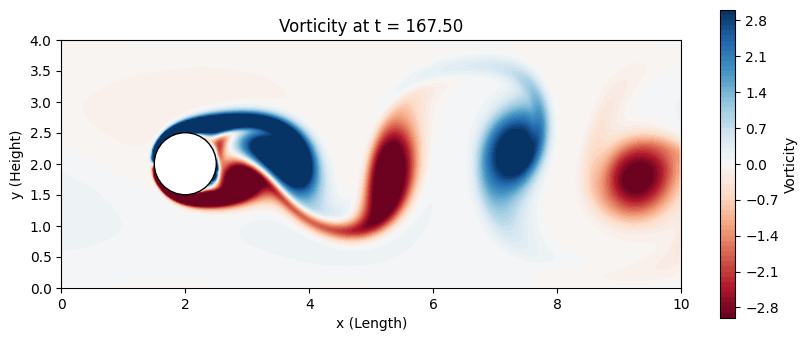

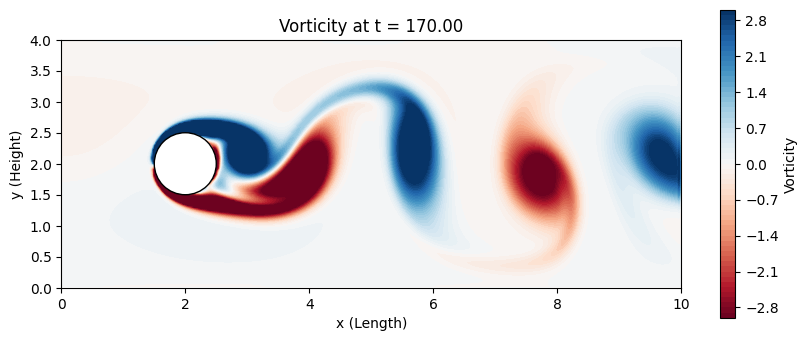

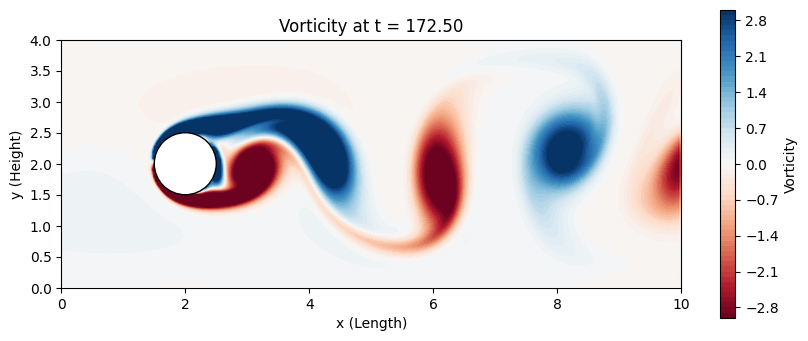

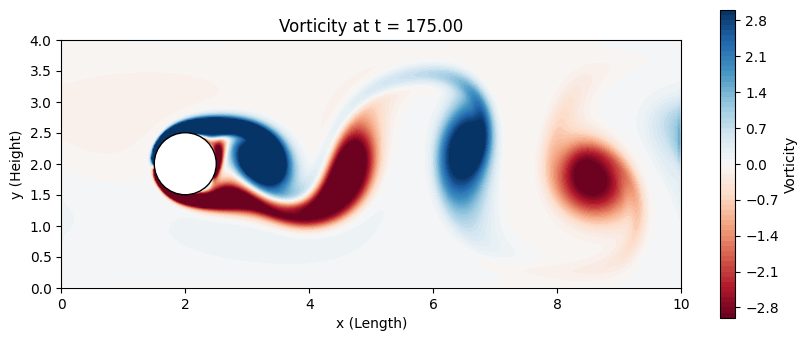

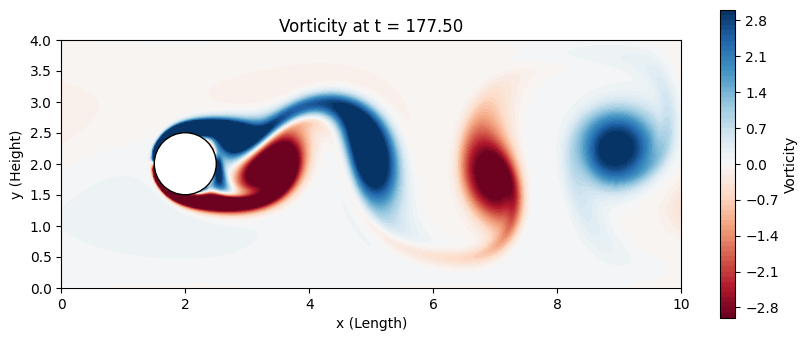

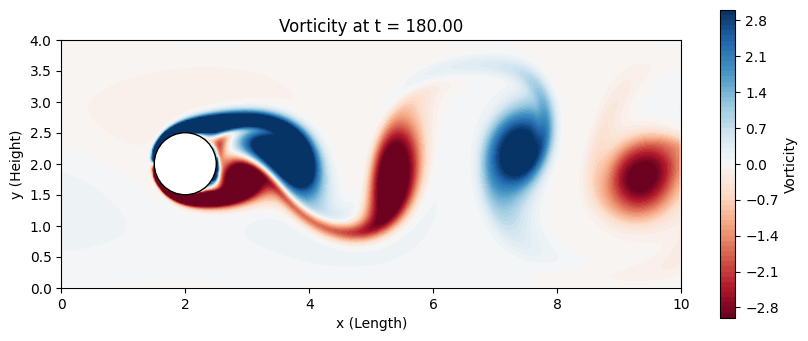

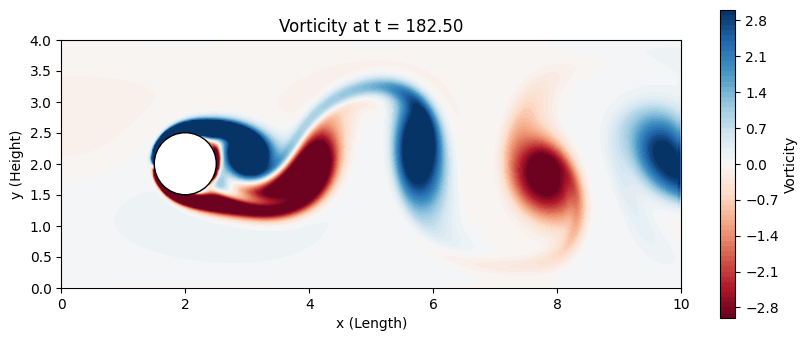

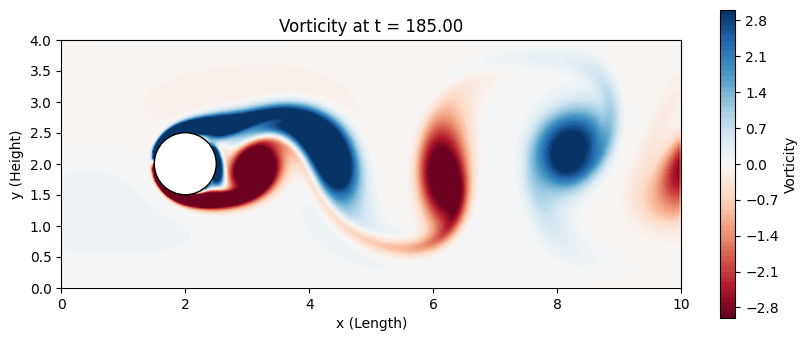

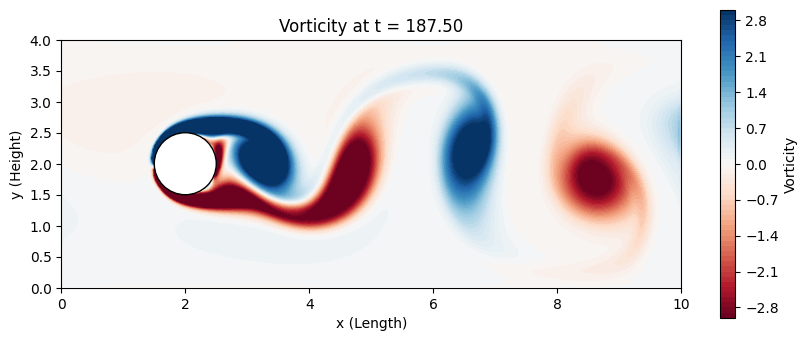

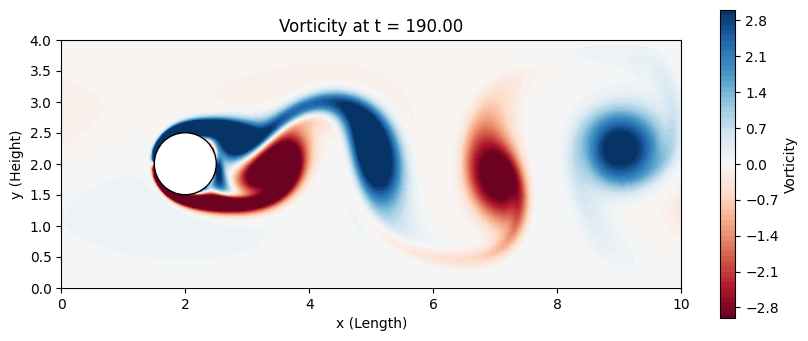

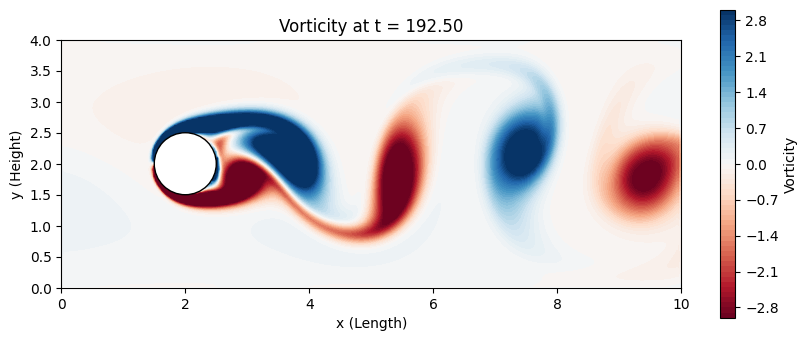

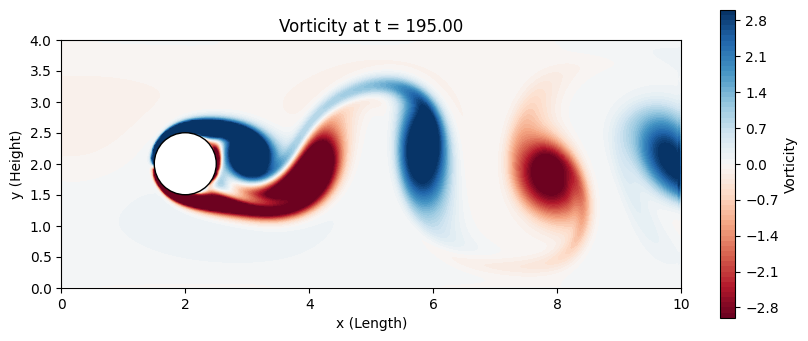

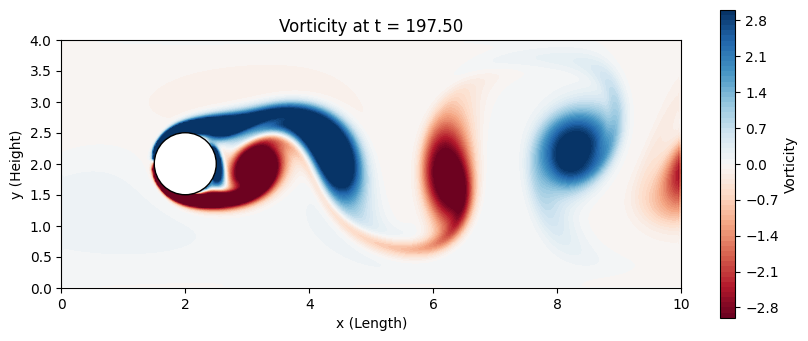

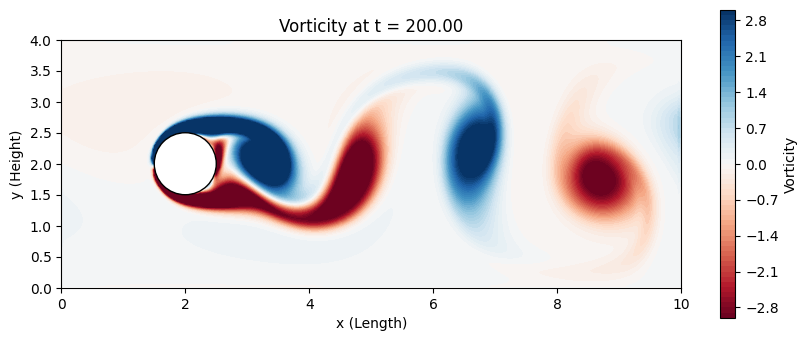

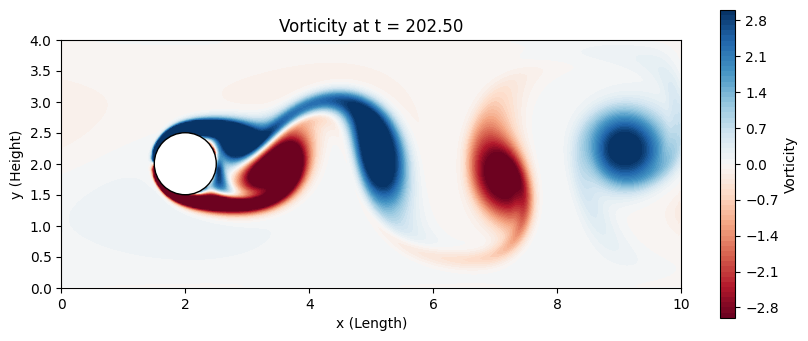

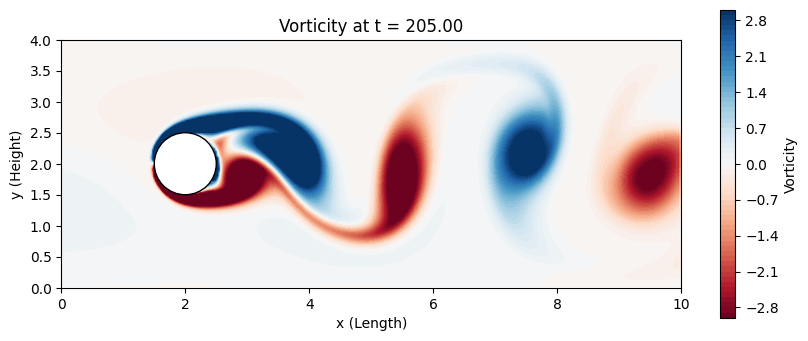

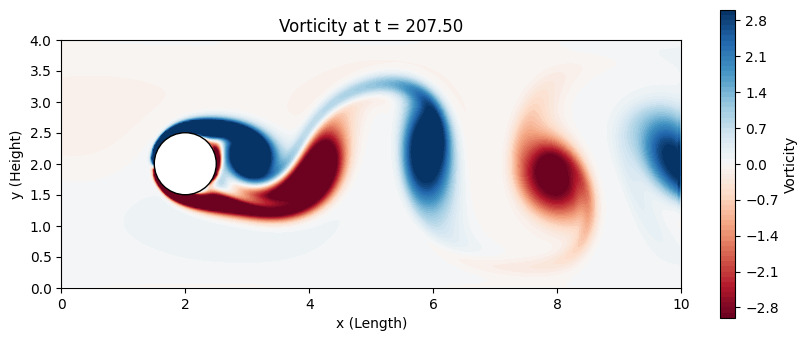

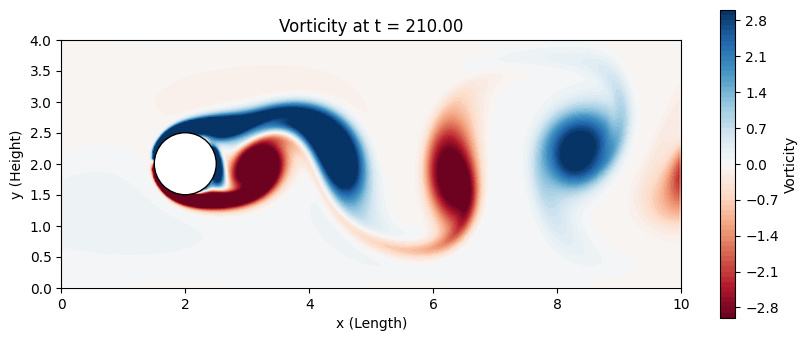

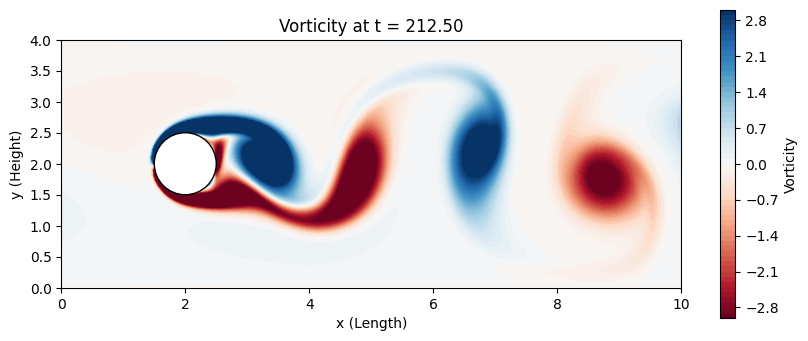

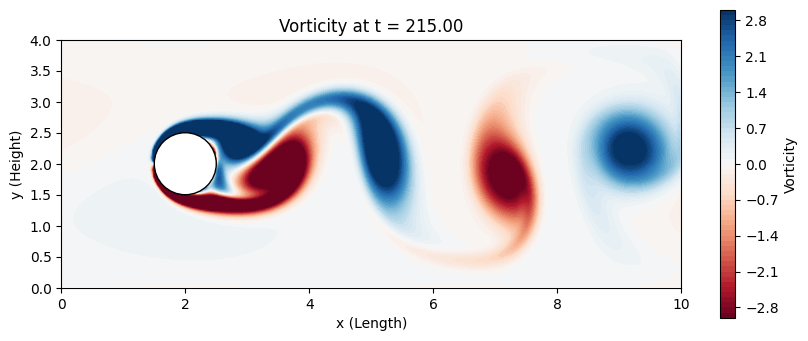

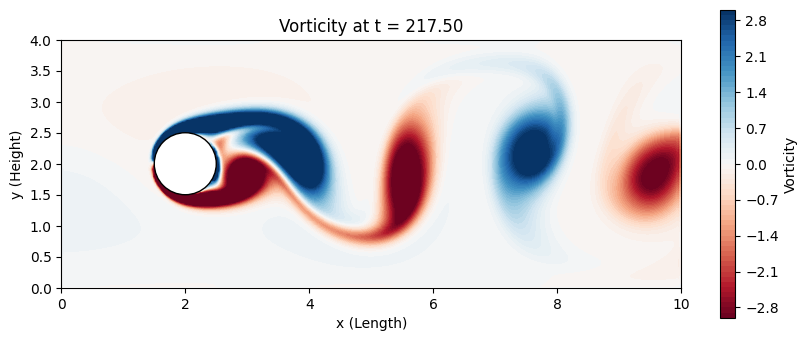

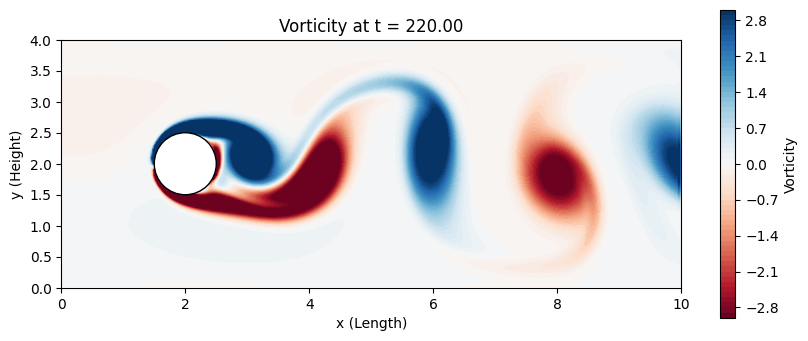

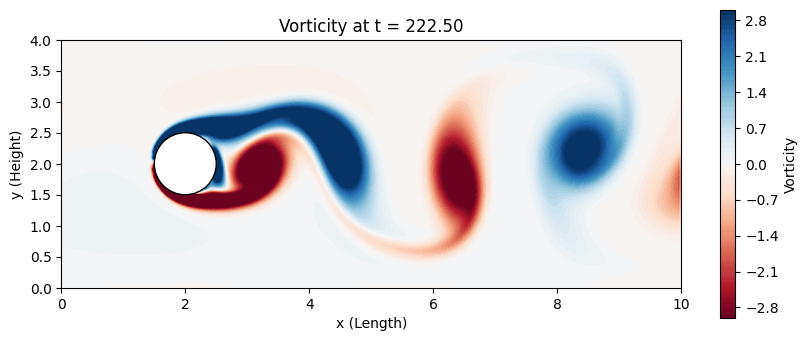

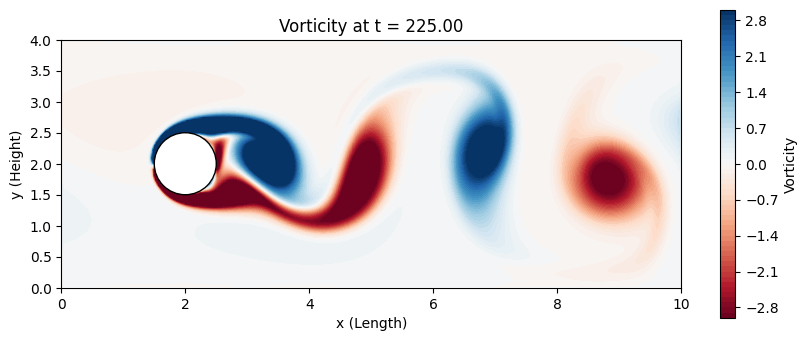

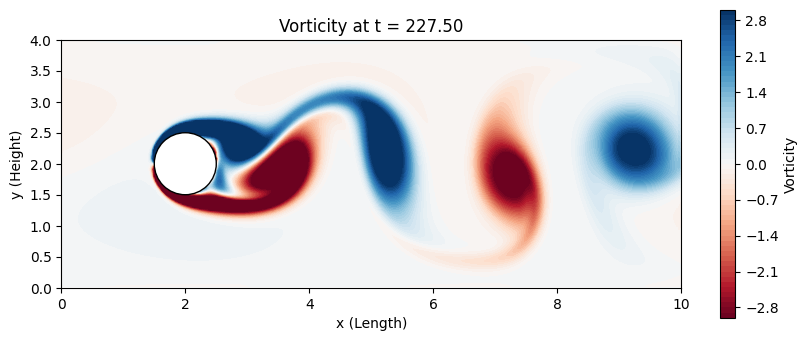

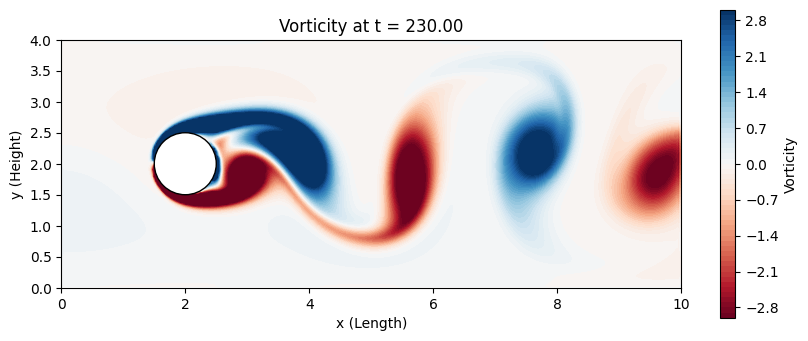

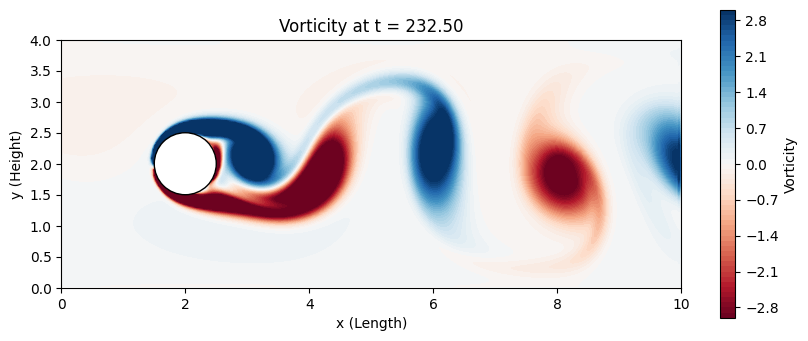

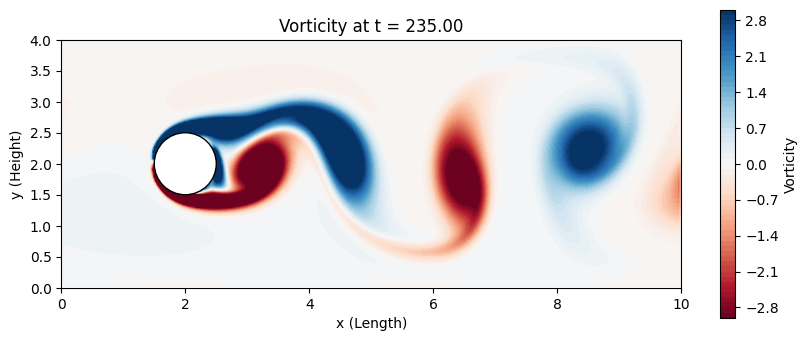

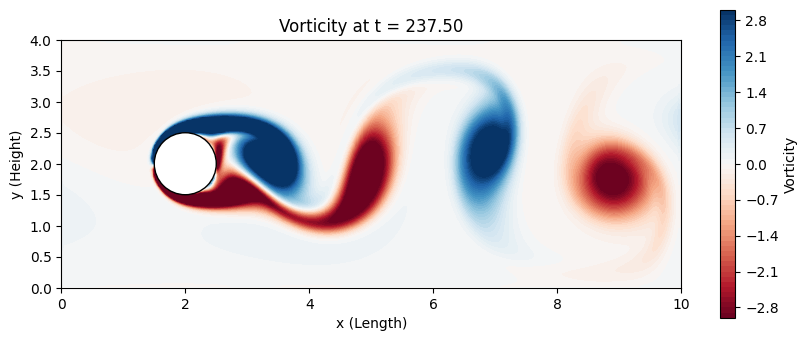

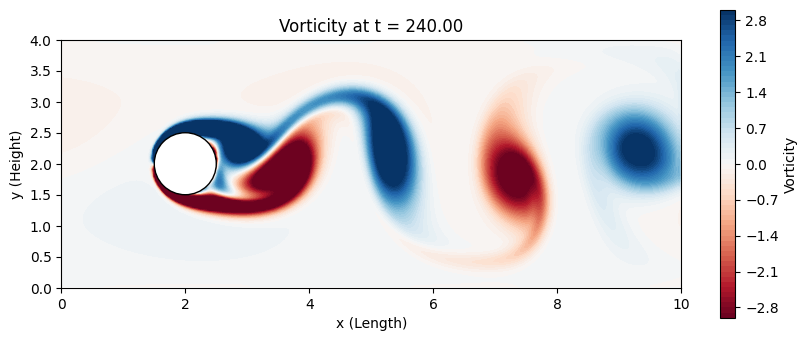

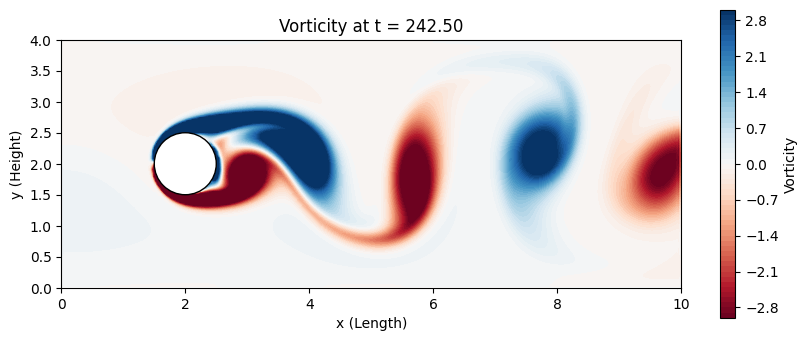

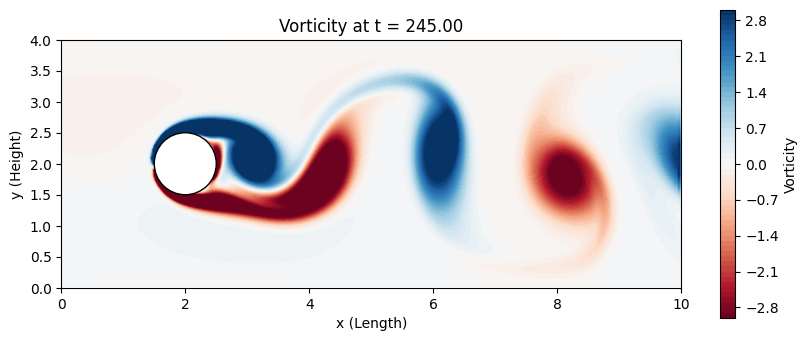

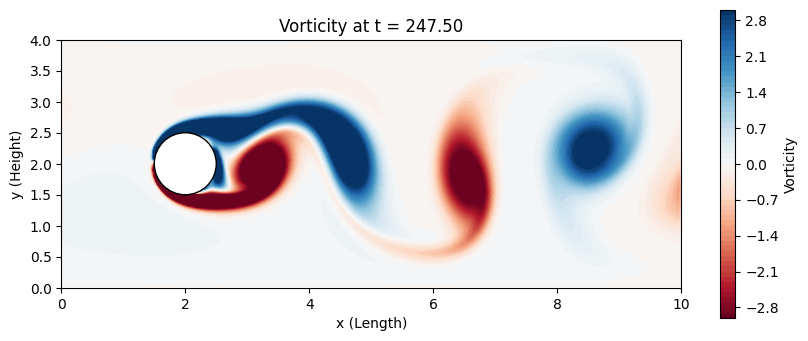

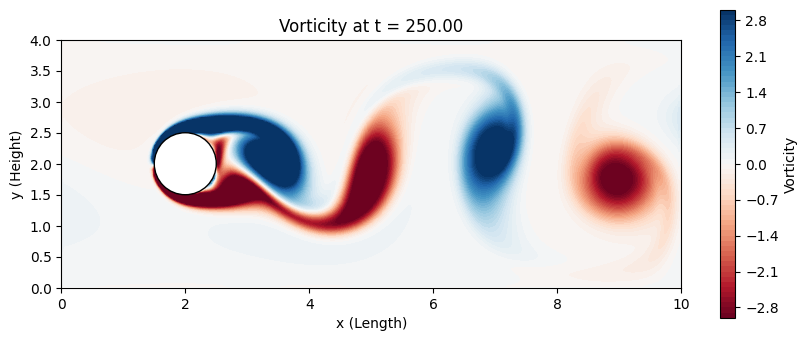

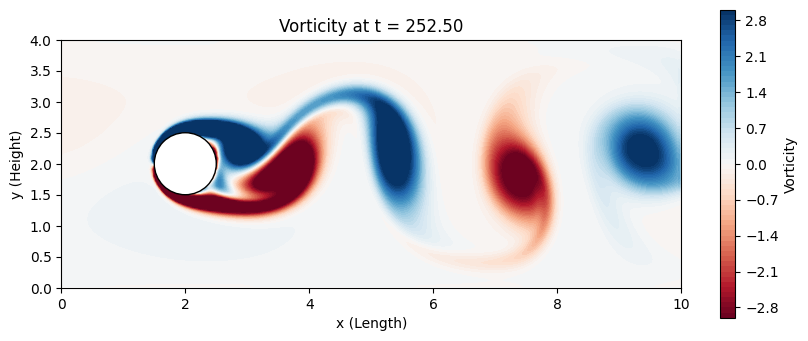

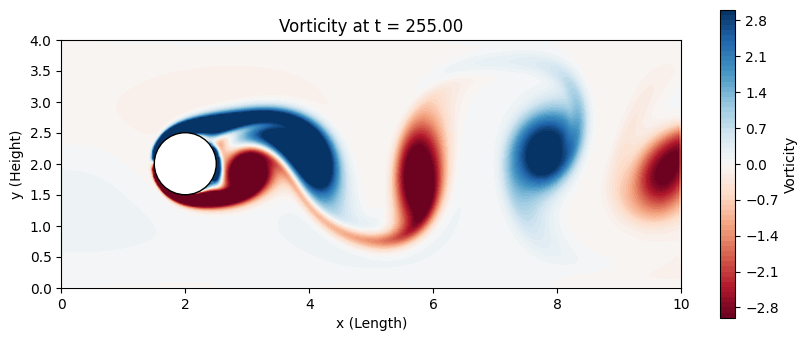

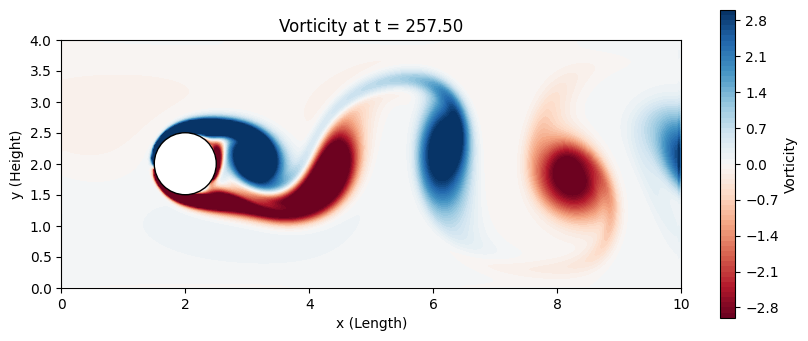

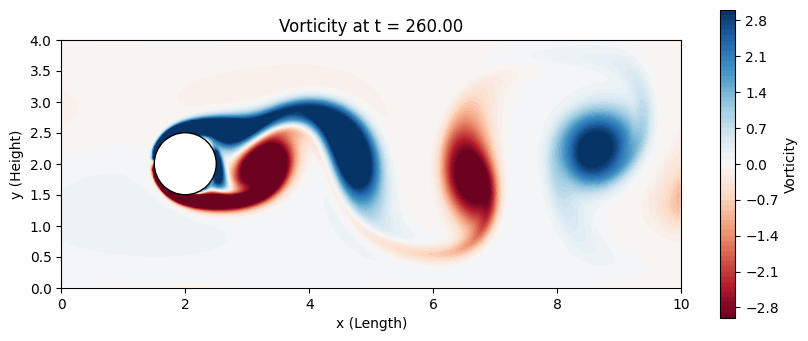

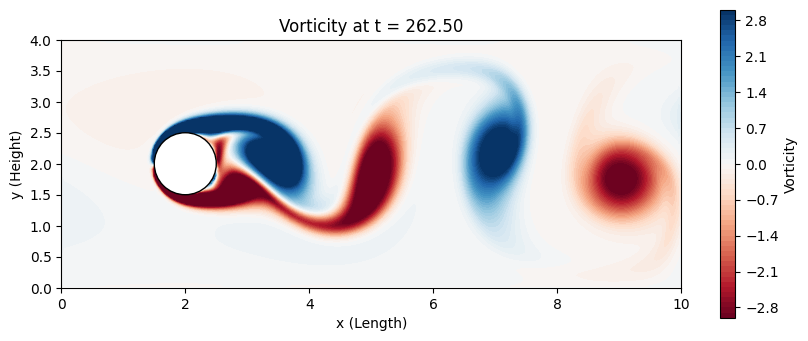

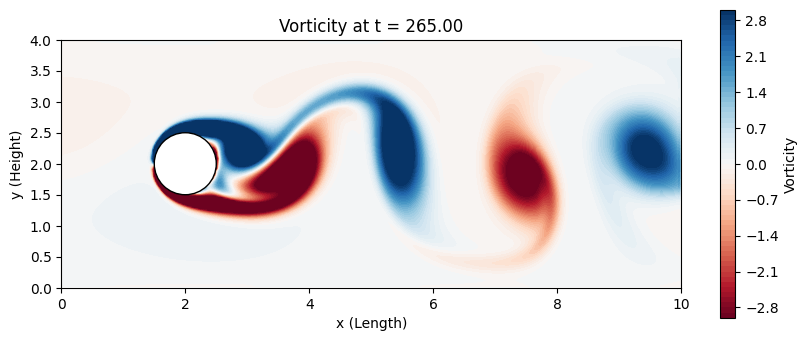

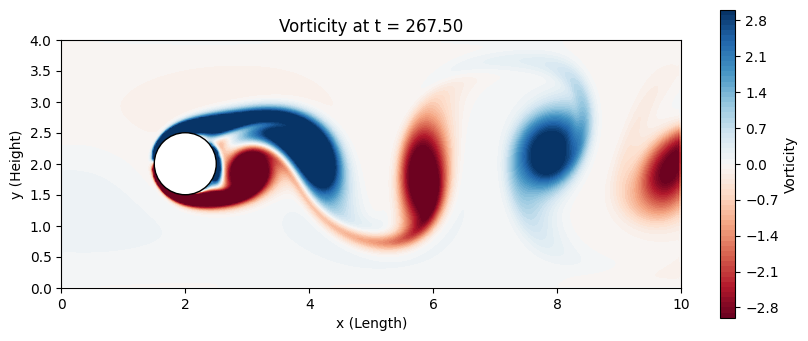

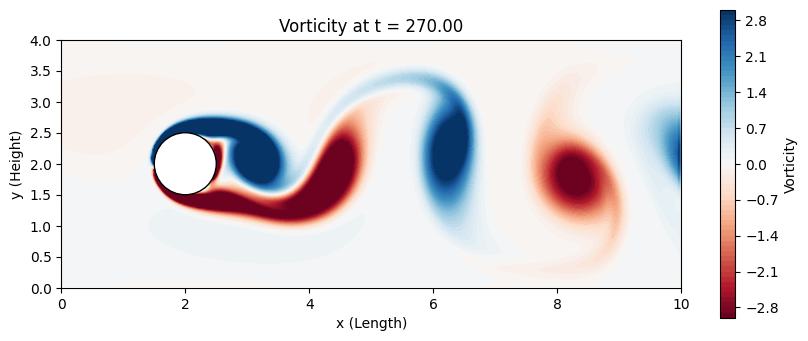

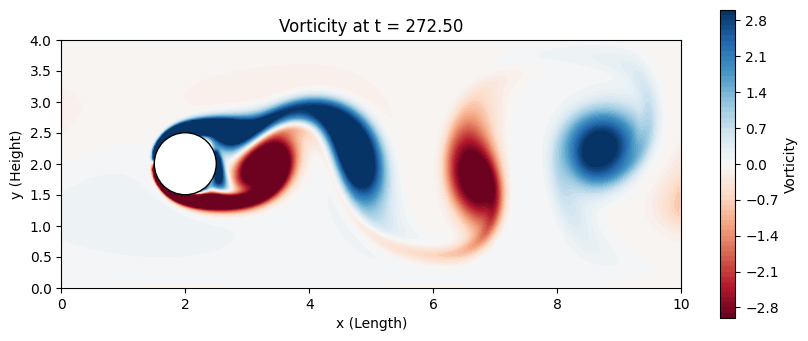

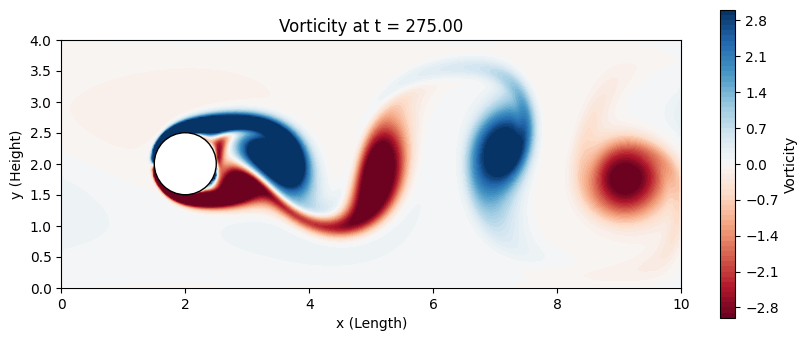

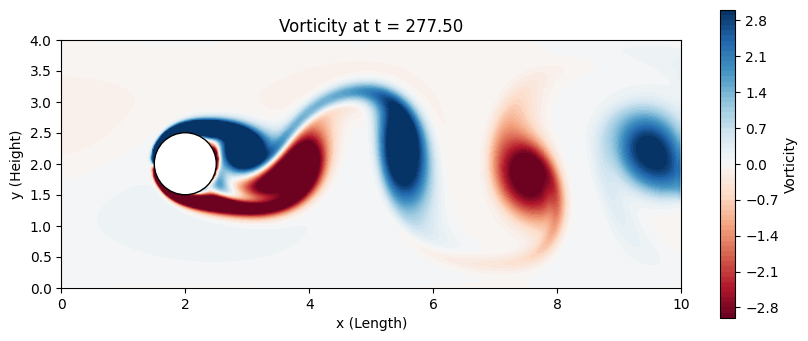

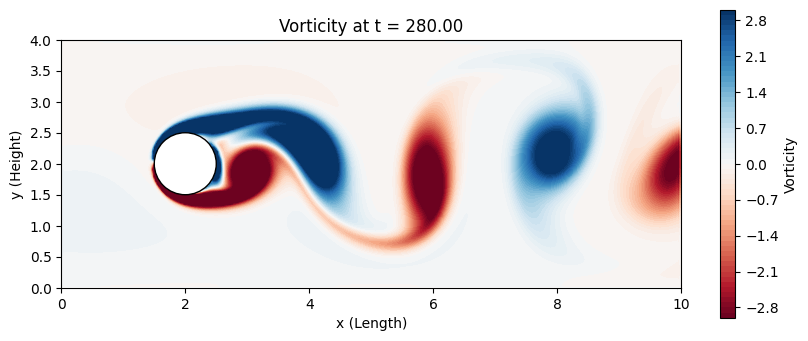

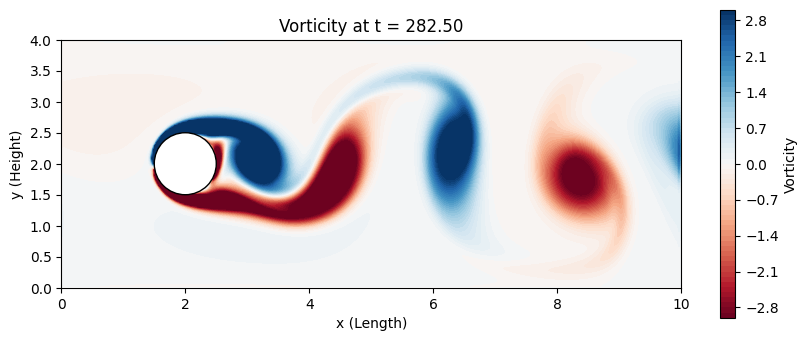

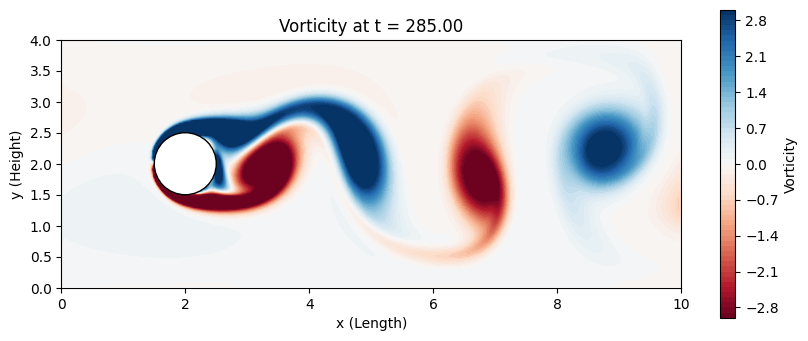

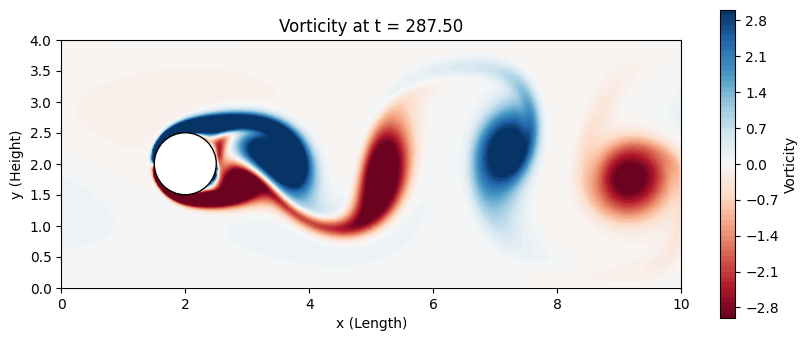

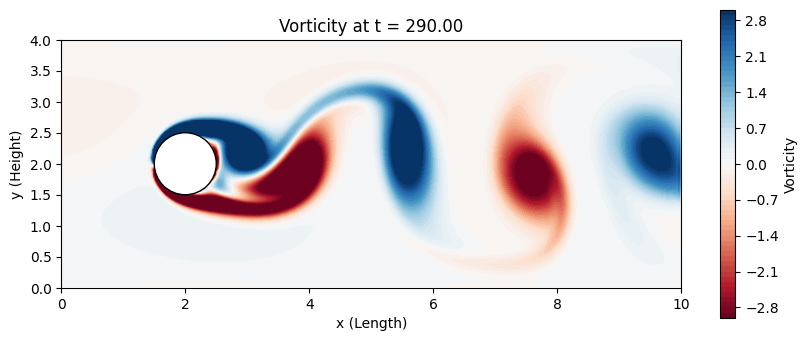

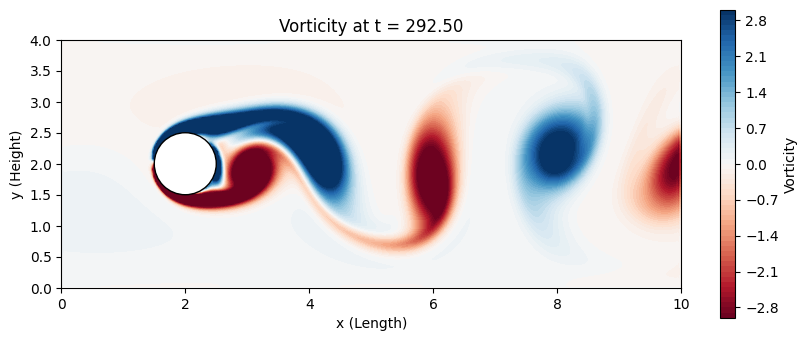

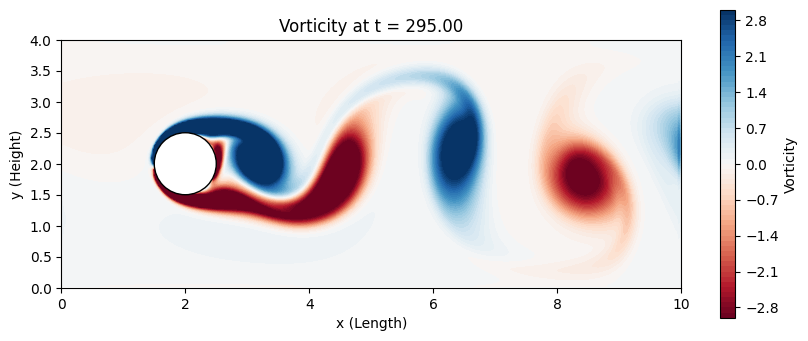

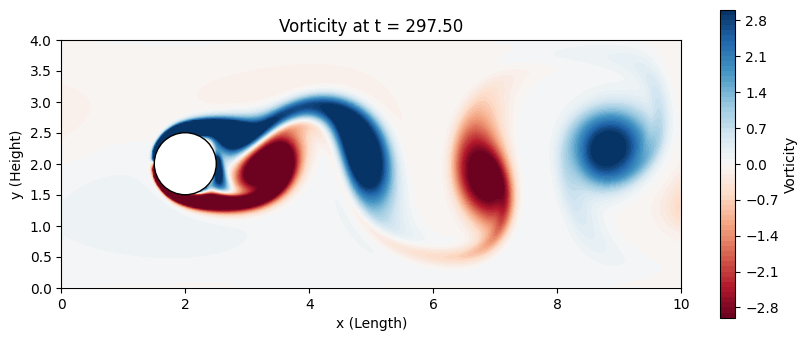

Simulation completed.


In [ ]:
# @title 2D Flow Simulation using CuPy for GPU Acceleration
"""
2D Flow Simulation using CuPy for GPU Acceleration
================================================

This code simulates a 2D fluid flow around a cylinder using the Navier-Stokes equations.
The simulation uses a lid-driven cavity setup with a cylindrical obstacle, implementing
the Alternating Direction Implicit (ADI) method for diffusion and a projection method
for pressure-velocity coupling.

Key Features:
- GPU-accelerated computation using CuPy
- Lid-driven cavity flow configuration
- Cylindrical obstacle in the flow field
- Vorticity calculation and visualization
- Force calculation on the cylinder
- Periodic snapshot saving

Dependencies:
- cupy: GPU acceleration library
- numpy: Numerical computations
- matplotlib: Visualization
- cupyx.scipy: Sparse matrix operations and FFT

Usage Instructions:
1. Ensure all required libraries are installed (cupy, numpy, matplotlib)
2. GPU with CUDA support is required for CuPy
3. Adjust simulation parameters as needed:
   - Nx, Ny: Grid resolution
   - Re: Reynolds number
   - Lx, Ly: Domain size
   - dt: Time step
   - Ulid: Lid velocity
   - snapshot_interval: Frequency of data saving
   - Nmax: Total simulation steps

Output:
1. Real-time visualization of vorticity field every 500 steps
2. Saved snapshots in 'snapshots' directory (when uncommented)
3. Final vorticity data saved as 'vorticity_snapshots.npy'
4. Force data on cylinder stored in Fs array

Notes:
- The simulation uses a lid-driven cavity configuration with a cylinder obstacle
- The flow field is initialized with uniform velocity
- The cylinder is placed at (Lx/5, Ly/2) with radius 0.5
- Boundary conditions:
  * Top wall: Moving lid (u = Ulid)
  * Other walls: No-slip
  * Cylinder: No-slip
- The code uses:
  * ADI method for diffusion
  * Projection method for pressure-velocity coupling
  * Spectral method for pressure Poisson equation

"""


import cupy as cp
import numpy as np
from cupyx.scipy.sparse import spdiags
from cupyx.scipy.fft import dct, idct
import matplotlib.pyplot as plt
import os

# Create directory for saving simulation snapshots
if not os.path.exists('snapshots'):
    os.makedirs('snapshots')

# Simulation Parameters
# -------------------
Nx, Ny = 100*4, 40*4          # Number of grid points in x and y directions
Re = 150                      # Reynolds number
Lx, Ly = 10, 4               # Domain dimensions
dt = 0.005                    # Time step
Ulid = 1                      # Lid velocity (top boundary)
dx, dy = Lx / Nx, Ly / Ny    # Grid spacing

# Initialize Flow Variables on GPU
# ------------------------------
u = cp.ones((Ny+2, Nx+2))    # x-component of velocity
v = cp.zeros((Ny+2, Nx+2))   # y-component of velocity
p = cp.ones((Ny+2, Nx+2))    # Pressure field
U = cp.ones((Ny, Nx+1))      # x-velocity at cell faces
V = cp.zeros((Ny+1, Nx))     # y-velocity at cell faces

# Simulation Control Parameters
# ---------------------------
Nmax = 60000                 # Maximum number of time steps
Fs = cp.zeros((Nmax, 2))     # Array to store forces on cylinder

# Snapshot Configuration
# --------------------
snapshot_interval = 20
num_snapshots = Nmax // snapshot_interval
snapshots = np.zeros((num_snapshots, Ny, Nx))
snapshots_u = np.zeros((num_snapshots, Ny, Nx))
snapshots_v = np.zeros((num_snapshots, Ny, Nx))
snapshot_counter = 0

# Setup Poisson Solver
# ------------------
# Create wave numbers for spectral solution
kx, ky = cp.meshgrid(cp.arange(Nx), cp.arange(Ny))
mwx = 2 * (cp.cos(cp.pi * kx / Nx) - 1) / dx**2
mwy = 2 * (cp.cos(cp.pi * ky / Ny) - 1) / dy**2

# Grid Generation
# -------------
xx = cp.linspace(-dx/2, Lx+dx/2, Nx+2)  # x-coordinates including ghost cells
yy = cp.linspace(-dy/2, Ly+dy/2, Ny+2)  # y-coordinates including ghost cells
x, y = cp.meshgrid(xx, yy)

# Cylinder Configuration
# --------------------
cx, cy = Lx / 5, Ly / 2      # Cylinder center coordinates
r = 0.5                      # Cylinder radius

# Create Boolean Masks for Geometry
# ------------------------------
mask_cylinder = (x - cx)**2 + (y - cy)**2 < r**2  # Points inside cylinder
mask_tube = cp.logical_not(mask_cylinder)         # Points outside cylinder

# Create mask for cylinder boundary
mask_boundary = cp.zeros_like(mask_cylinder, dtype=bool)
mask_boundary[1:-1, 1:-1] = cp.logical_xor(
    mask_cylinder[1:-1, 1:-1],
    mask_cylinder[:-2, 1:-1] & mask_cylinder[2:, 1:-1] &
    mask_cylinder[1:-1, :-2] & mask_cylinder[1:-1, 2:]
)

# Precompute boundary neighbor masks for force calculation
boundL_neigh = cp.roll(mask_boundary, 1, axis=1)   # Left neighbors
boundR_neigh = cp.roll(mask_boundary, -1, axis=1)  # Right neighbors
boundT_neigh = cp.roll(mask_boundary, 1, axis=0)   # Top neighbors
boundB_neigh = cp.roll(mask_boundary, -1, axis=0)  # Bottom neighbors

# ADI Method Setup
# --------------
mu = 1 / Re  # Kinematic viscosity

# Create tridiagonal matrices for implicit solving
e = cp.ones(Nx)
Ax = spdiags([-mu*0.5*dt*e/dx**2, (1 + mu*dt/dx**2)*e, -mu*0.5*dt*e/dx**2],
            [-1, 0, 1], Nx, Nx).toarray()
e = cp.ones(Ny)
Ay = spdiags([-mu*0.5*dt*e/dy**2, (1 + mu*dt/dy**2)*e, -mu*0.5*dt*e/dy**2],
            [-1, 0, 1], Ny, Ny).toarray()

def ADI(dt, dx, dy, mu, u, Ax, Ay):
    """
    Alternating Direction Implicit (ADI) method for solving the diffusion equation.

    Parameters:
    -----------
    dt : float
        Time step
    dx, dy : float
        Grid spacing in x and y directions
    mu : float
        Kinematic viscosity
    u : cp.ndarray
        Velocity field to be diffused
    Ax, Ay : cp.ndarray
        Tridiagonal matrices for implicit solving

    Returns:
    --------
    u : cp.ndarray
        Updated velocity field after diffusion
    """
    # Implicit step in x-direction
    b_x = u[1:-1, 1:-1] + 0.5 * dt * mu * (u[2:, 1:-1] + u[:-2, 1:-1] -
                                          2 * u[1:-1, 1:-1]) / dy**2
    b_x[:, 0] += mu * 0.5 * dt * u[1:-1, 1] / dx**2
    b_x[:, -1] += mu * 0.5 * dt * u[1:-1, -2] / dx**2
    u[1:-1, 1:-1] = cp.linalg.solve(Ax, b_x.T).T

    # Implicit step in y-direction
    b_y = u[1:-1, 1:-1] + 0.5 * dt * mu * (u[1:-1, 2:] + u[1:-1, :-2] -
                                          2 * u[1:-1, 1:-1]) / dx**2
    b_y[0, :] += mu * 0.5 * dt * u[1, 1:-1] / dy**2
    b_y[-1, :] += mu * 0.5 * dt * u[-2, 1:-1] / dy**2
    u[1:-1, 1:-1] = cp.linalg.solve(Ay, b_y)

    return u

# Main Simulation Loop
# ------------------
for i in range(Nmax):
    # 1. Velocity Interpolation at Cell Faces
    # -------------------------------------
    # Interpolate u-velocity
    u_w = 0.5 * (u[1:-1, :-2] + u[1:-1, 1:-1])  # Western face
    u_e = 0.5 * (u[1:-1, 2:] + u[1:-1, 1:-1])   # Eastern face
    u_n = 0.5 * (u[2:, 1:-1] + u[1:-1, 1:-1])   # Northern face
    u_s = 0.5 * (u[:-2, 1:-1] + u[1:-1, 1:-1])  # Southern face

    # Interpolate v-velocity
    v_w = 0.5 * (v[1:-1, :-2] + v[1:-1, 1:-1])
    v_e = 0.5 * (v[1:-1, 2:] + v[1:-1, 1:-1])
    v_n = 0.5 * (v[2:, 1:-1] + v[1:-1, 1:-1])
    v_s = 0.5 * (v[:-2, 1:-1] + v[1:-1, 1:-1])

    # 2. Compute Convection Terms
    # -------------------------
    conu = ((U[:, 1:] * u_e - U[:, :-1] * u_w) / dx) + \
           ((V[1:, :] * u_n - V[:-1, :] * u_s) / dy)

    conv = ((U[:, 1:] * v_e - U[:, :-1] * v_w) / dx) + \
           ((V[1:, :] * v_n - V[:-1, :] * v_s) / dy)

    # 3. Predictor Step
    # ---------------
    us = u.copy()  # Intermediate u-velocity
    vs = v.copy()  # Intermediate v-velocity
    us[1:-1, 1:-1] = u[1:-1, 1:-1] - dt * conu
    vs[1:-1, 1:-1] = v[1:-1, 1:-1] - dt * conv

    # 4. Solve Diffusion using ADI
    # --------------------------
    us = ADI(dt, dx, dy, mu, us, Ax, Ay)
    vs = ADI(dt, dx, dy, mu, vs, Ax, Ay)

    # 5. Interpolate Velocities at Cell Faces
    # ------------------------------------
    Us = 0.5 * (us[1:-1, 1:] + us[1:-1, :-1])
    Vs = 0.5 * (vs[1:, 1:-1] + vs[:-1, 1:-1])

    # 6. Apply Lid-Driven Boundary Conditions
    # -----------------------------------
    Us[:, 0] = Ulid
    Us[:, -1] = Ulid

    # 7. Compute Divergence for Pressure Poisson Equation
    # ----------------------------------------------
    F = ((Us[:, 1:] - Us[:, :-1]) / dx + \
         (Vs[1:, :] - Vs[:-1, :]) / dy) / dt

    # Set divergence to zero inside cylinder
    F[mask_cylinder[1:-1, 1:-1]] = 0

    # 8. Solve Pressure Poisson Equation
    # -------------------------------
    B = dct(dct(F, axis=0, norm='ortho'), axis=1, norm='ortho')
    A = B / (mwx + mwy)
    A[0, 0] = 0  # Set mean pressure to zero
    p[1:-1, 1:-1] = idct(idct(A, axis=1, norm='ortho'), axis=0, norm='ortho')

    # 9. Apply Pressure Boundary Conditions
    # ---------------------------------
    p[:, 0] = p[:, 1]     # Left wall
    p[:, -1] = p[:, -2]   # Right wall
    p[0, :] = p[1, :]     # Bottom wall
    p[-1, :] = p[-2, :]   # Top wall

    # 10. Velocity Correction Step
    # -------------------------
    # Correct cell-centered velocities
    u[1:-1, 1:-1] = us[1:-1, 1:-1] - dt * (p[1:-1, 2:] - p[1:-1, :-2]) / (2 * dx)
    v[1:-1, 1:-1] = vs[1:-1, 1:-1] - dt * (p[2:, 1:-1] - p[:-2, 1:-1]) / (2 * dy)

    # Correct face velocities
    U[:, 1:-1] = Us[:, 1:-1] - dt * (p[1:-1, 2:-1] - p[1:-1, 1:-2]) / dx
    V[1:-1, :] = Vs[1:-1, :] - dt * (p[2:-1, 1:-1] - p[1:-2, 1:-1]) / dy

    # 11. Apply Velocity Boundary Conditions
    # ----------------------------------
    # u-velocity boundaries
    u[0, :] = u[1, :]                 # Bottom wall
    u[-1, :] = u[-2, :]               # Top wall
    u[:, 0] = 2 * Ulid - u[:, 1]      # Left wall
    u[:, -1] = 2 * Ulid - u[:, -2]    # Right wall

    # v-velocity boundaries
    v[:, 0] = -v[:, 1]                # Left wall
    v[:, -1] = v[:, -2]               # Right wall
    v[0, :] = -v[1, :]                # Bottom wall
    v[-1, :] = -v[-2, :]              # Top wall

    # 12. Apply Cylinder Boundary Conditions
    # ----------------------------------
    u[mask_cylinder] = 0
    v[mask_cylinder] = 0

    # 13. Calculate Forces on Cylinder
    # ----------------------------
    # x-component of force
    Fs[i, 0] = 2 * dx * cp.sum(0.5 * (p[mask_boundary] + p[boundL_neigh]) *
                               mask_cylinder[boundR_neigh] -
                               0.5 * (p[mask_boundary] + p[boundR_neigh]) *
                               mask_cylinder[boundL_neigh])
    # y-component of force
    Fs[i, 1] = -2 * dy * cp.sum(0.5 * (p[mask_boundary] + p[boundT_neigh]) *
                                mask_cylinder[boundB_neigh] -
                                0.5 * (p[mask_boundary] + p[boundB_neigh]) *
                                mask_cylinder[boundT_neigh])

    # 14. Save Snapshots
    # ---------------
    if i % snapshot_interval == 0:
        # Calculate vorticity
        vort = (u[2:, 1:-1] - u[:-2, 1:-1]) / (2 * dy) - \
               (v[1:-1, 2:] - v[1:-1, :-2]) / (2 * dx)
        vort_cpu = cp.asnumpy(vort)
        u_cpu = cp.asnumpy(u[1:-1:, 1:-1])
        v_cpu = cp.asnumpy(v[1:-1:, 1:-1])
        snapshots[snapshot_counter] = vort_cpu
        snapshots_u[snapshot_counter] = u_cpu
        snapshots_u[snapshot_counter] = v_cpu
        snapshots[snapshot_counter] = vort_cpu
        snapshot_counter += 1

    # 15. Visualization
    # --------------
    if i % 500 == 0:
        # Calculate vorticity
        vort = (u[2:, 1:-1] - u[:-2, 1:-1]) / (2 * dy) - \
               (v[1:-1, 2:] - v[1:-1, :-2]) / (2 * dx)

        # Clip vorticity for better visualization
        vort_clipped = cp.clip(vort, -3.0, 3.0)

        # Transfer data to CPU for plotting
        xx_cpu = cp.asnumpy(xx)
        yy_cpu = cp.asnumpy(yy)
        vort_clipped_cpu = cp.asnumpy(vort_clipped)

        # Create visualization plot
        plt.figure(figsize=(10, 4))
        plt.contourf(xx_cpu[1:-1], yy_cpu[1:-1], vort_clipped_cpu,
                    levels=np.arange(-3.0, 3.1, 0.1),
                    cmap='RdBu')  # Red-Blue colormap for vorticity
        plt.colorbar(label='Vorticity')

        # Add cylinder visualization
        circle = plt.Circle((cx, cy), r,
                          facecolor='white',
                          edgecolor='black',
                          linewidth=1.0)
        plt.gca().add_artist(circle)

        # Set plot parameters
        plt.xlim([0, Lx])
        plt.ylim([0, Ly])
        plt.xlabel('x (Length)')
        plt.ylabel('y (Height)')
        plt.title(f'Vorticity at t = {dt * i:.2f}')
        plt.gca().set_aspect('equal', adjustable='box')

        # Uncomment to save plots
        #plt.savefig(f'snapshots/vorticity_t{i:06d}.png',
        #            dpi=300,
        #            bbox_inches='tight')

        plt.show()
        plt.close()

# 16. Save Final Results
# -------------------
# Save all vorticity snapshots to file
np.save('snapshots/vorticity_snapshots.npy', snapshots)
np.save('snapshots/u_snapshots.npy', snapshots_u)
np.save('snapshots/v_snapshots.npy', snapshots_v)
print("Simulation completed.")

In [ ]:
# @title Vorticity Data Preprocessing and Loading Framework
"""
Vorticity Data Preprocessing and Loading Framework
===============================================

This code implements a comprehensive data processing pipeline for fluid dynamics simulations,
specifically designed for vorticity field data. It includes spatial downsampling/upsampling,
data vectorization, and a custom data loader for sequence-to-sequence prediction tasks.

Key Features:
- Spatial dimension reduction through downsampling
- Cubic interpolation for upsampling
- Vectorization of spatial dimensions for ML processing
- Custom data loader with train/val/test split
- TensorFlow dataset integration with batch processing and prefetching


Usage Notes:
1. The data pipeline expects vorticity field data from CFD simulations
2. Spatial downsampling reduces computational requirements
3. Data is vectorized for ML processing but can be devectorized for visualization
4. The dataloader creates sequence pairs for training sequence-to-sequence models
5. Use the calculated steps_per_epoch when training with model.fit()

"""

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import AdamW, SGD
from tensorflow.keras import backend as K
from scipy.interpolate import RegularGridInterpolator

# Clear any existing TensorFlow session
K.clear_session()

# Set random seeds for reproducibility

np.random.seed(888)

# Training parameters
batch_size = 64  # Number of samples per batch
seq_len = 64     # Length of input sequence
pred_len = 64    # Length of prediction sequence
downsample_factor = 3  # Downsampling factor for spatial dimensions

def downsample_data(data, factor=3):
    """
    Downsample the spatial dimensions of the vorticity field.

    Parameters:
    -----------
    data : ndarray
        Input data with shape (time_steps, height, width)
    factor : int
        Downsampling factor for spatial dimensions

    Returns:
    --------
    ndarray
        Downsampled data with reduced spatial dimensions
    """
    return data[:, ::factor, ::factor]

def upsample_data(data, original_shape):
    """
    Upsample the spatial dimensions back to original size using cubic interpolation.

    Parameters:
    -----------
    data : ndarray
        Downsampled data with shape (time_steps, height, width)
    original_shape : tuple
        Target shape for upsampling (time_steps, height, width)

    Returns:
    --------
    ndarray
        Upsampled data matching the original spatial dimensions
    """
    nt, ny, nx = data.shape
    ny_orig, nx_orig = original_shape[1:]
    upsampled_data = np.zeros((nt, ny_orig, nx_orig))

    # Create normalized coordinate grids
    y = np.linspace(0, 1, ny)
    x = np.linspace(0, 1, nx)
    y_new = np.linspace(0, 1, ny_orig)
    x_new = np.linspace(0, 1, nx_orig)

    # Perform cubic interpolation for each time step
    for t in range(nt):
        interpolator = RegularGridInterpolator((y, x), data[t],
                                             method='cubic',
                                             bounds_error=False,
                                             fill_value=None)
        yy, xx = np.meshgrid(y_new, x_new, indexing='ij')
        points = np.stack((yy.ravel(), xx.ravel()), axis=-1)
        upsampled_data[t] = interpolator(points).reshape(ny_orig, nx_orig)

    return upsampled_data

def vectorize_spatial(data):
    """
    Flatten spatial dimensions into a single vector for ML processing.

    Parameters:
    -----------
    data : ndarray
        Input data with shape (time_steps, height, width)

    Returns:
    --------
    ndarray
        Flattened data with shape (time_steps, height*width)
    """
    return data.reshape(data.shape[0], -1)

def devectorize_spatial(data, ny, nx):
    """
    Restore flattened data back to original spatial dimensions.

    Parameters:
    -----------
    data : ndarray
        Vectorized data with shape (batch_size, time_steps, features) or (time_steps, features)
    ny, nx : int
        Original spatial dimensions

    Returns:
    --------
    ndarray
        Reconstructed data with original spatial dimensions
    """
    if len(data.shape) == 2:  # No batch dimension
        return data.reshape(-1, ny, nx)
    elif len(data.shape) == 3:  # With batch dimension
        return data.reshape(data.shape[0], data.shape[1], ny, nx)
    else:
        raise ValueError("Unexpected input shape. Expected 2D or 3D array.")

class VorticityDataLoader:
    """
    Custom data loader for vorticity field sequence prediction.

    Features:
    - Handles sequence-to-sequence data preparation
    - Implements train/validation/test splitting
    - Creates TensorFlow datasets with batching and prefetching
    - Supports shuffling for training data
    """

    def __init__(self, data, batch_size, seq_len, pred_len):
        """
        Initialize the data loader.

        Parameters:
        -----------
        data : ndarray
            Vectorized vorticity data with shape (time_steps, spatial_features)
        batch_size : int
            Number of samples per batch
        seq_len : int
            Length of input sequence
        pred_len : int
            Length of prediction sequence
        """
        self.data = data
        self.batch_size = batch_size
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.nt, self.n_spatial = data.shape

    def create_dataset(self, start_idx, end_idx, shuffle=False, repeat=False):
        """
        Create a TensorFlow dataset for a specific data split.

        Parameters:
        -----------
        start_idx, end_idx : int
            Start and end indices for the data split
        shuffle : bool
            Whether to shuffle the data
        repeat : bool
            Whether to repeat the dataset indefinitely

        Returns:
        --------
        tf.data.Dataset
            Dataset configured with batching and prefetching
        """
        def gen():
            indices = list(range(start_idx, end_idx - self.seq_len - self.pred_len + 1))
            while True:
                if shuffle:
                    np.random.shuffle(indices)
                for i in indices:
                    yield (self.data[i:i+self.seq_len],
                          self.data[i+self.pred_len:i+self.seq_len+self.pred_len])
                if not repeat:
                    break

        dataset = tf.data.Dataset.from_generator(
            gen,
            output_signature=(
                tf.TensorSpec(shape=(self.seq_len, self.n_spatial), dtype=tf.float32),
                tf.TensorSpec(shape=(self.seq_len, self.n_spatial), dtype=tf.float32)
            )
        )

        if shuffle:
            dataset = dataset.shuffle(buffer_size=10000)

        return dataset.batch(self.batch_size).prefetch(tf.data.AUTOTUNE)

    def get_train(self, train_split=0.7):
        """Get the training dataset."""
        train_end = int(self.nt * train_split)
        return self.create_dataset(0, train_end, shuffle=True, repeat=True)

    def get_val(self, train_split=0.7, val_split=0.15):
        """Get the validation dataset."""
        train_end = int(self.nt * train_split)
        val_end = train_end + int(self.nt * val_split)
        return self.create_dataset(train_end, val_end, shuffle=False, repeat=False)

    def get_test(self, train_split=0.7, val_split=0.15):
        """Get the test dataset."""
        train_end = int(self.nt * train_split)
        val_end = train_end + int(self.nt * val_split)
        return self.create_dataset(val_end, self.nt, shuffle=False, repeat=False)

# Example Usage and Setup
# ----------------------

# Load and preprocess data
data_original = np.load('./snapshots/vorticity_snapshots.npy')
data = downsample_data(data_original, factor=downsample_factor)


nt, ny, nx = data.shape

# Set up simulation parameters
Nmax = 60000                      # Total simulation steps
lx, ly = 10, 4                    # Domain dimensions
dt = 0.005 * Nmax / nt           # Time step
dx, dy = lx / nx, ly / ny        # Spatial steps

# Create coordinate axes
xx = np.arange(nx) * dx          # x-coordinates
yy = np.arange(ny) * dy          # y-coordinates
tt = np.arange(nt) * dt          # time coordinates

# Prepare data for ML processing
data_vectorized = vectorize_spatial(data)

# Initialize data loader
dataloader = VorticityDataLoader(data_vectorized, batch_size, seq_len, pred_len)

# Create train/val/test datasets
train_data = dataloader.get_train()
val_data = dataloader.get_val()
test_data = dataloader.get_test()

# Calculate training steps per epoch
steps_per_epoch = (int(dataloader.nt * 0.7) - seq_len - pred_len + 1) // batch_size

# Verify data shapes and processing
for inputs, labels in train_data.take(1):
    print("Vectorized input shape:", inputs.shape)
    print("Vectorized label shape:", labels.shape)
    devectorized_inputs = devectorize_spatial(inputs.numpy(), ny, nx)
    print("Devectorized input shape:", devectorized_inputs.shape)

print("Steps per epoch:", steps_per_epoch)


Vectorized input shape: (64, 64, 7236)
Vectorized label shape: (64, 64, 7236)
Devectorized input shape: (64, 64, 54, 134)
Steps per epoch: 30


In [ ]:
# @title FlowMixer Model
"""
FlowMixer Model
========================

A specialized neural network architecture, combining
reversible normalization, dropout, noise injection (optional), and mixing operations. The model
is designed to capture both temporal and spatial correlations in flow data.

Key Components:
- Reversible Instance Normalization (RevNorm)
- Noise Injection Layer
- Mixing Module (Dual Projection)
- FlowMixer (Main Model)


Usage Example:
model = FlowMixer(
    seq_len=64,          # Length of input sequence
    nb_features=100,     # Number of spatial features
    pred_len=32,         # Length of prediction sequence
    dropout_rate=0.1,    # Dropout rate for regularization
    noise_factor=0.0    # Scale of noise injection
)

# Compile the model
model.compile(
    optimizer='adam',
    loss='mse'
)

# Train the model
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100
)
"""

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import io

class RevNorm(tf.keras.layers.Layer):
    """
    Reversible Instance Normalization Layer

    Performs normalization that can be reversed during inference, helping
    preserve the scale of the original data. (Kim et al., 2022)

    Attributes:
        axis (int): Normalization axis
        eps (float): Small constant for numerical stability
        affine (bool): Whether to apply affine transformation
        revin (int): Type of RevIN (1: Type I, 2: Type II TD-REVIN)
    """
    def __init__(self, axis=1, eps=1e-5, affine=True, revin=1):
        super().__init__()
        self.axis = axis
        self.eps = eps
        self.affine = affine
        self.revin = revin
        # Initialize weights as None
        self.affine_weight = None
        self.affine_bias = None
        self.mean = None
        self.stdev = None

    def build(self, input_shape):
        """Initialize affine transformation parameters if enabled."""
        if self.affine:
            if self.revin == 1:
                param_shape = (input_shape[-1],)  # Type I: feature-wise
            else:
                param_shape = (1, input_shape[-2], input_shape[-1],)  # Type II: temporal-feature-wise

            self.affine_weight = self.add_weight(
                name='affine_weight',
                shape=param_shape,
                initializer='ones',
                trainable=True
            )
            self.affine_bias = self.add_weight(
                name='affine_bias',
                shape=param_shape,
                initializer='zeros',
                trainable=True
            )

    def call(self, x, mode):
        """
        Apply normalization or denormalization.

        Args:
            x: Input tensor
            mode: 'norm' for normalization, 'denorm' for denormalization
        """
        if mode == 'norm':
            self.mean, self.stdev = self._get_statistics(x)
            return self._normalize(x)
        elif mode == 'denorm':
            return self._denormalize(x)
        else:
            raise NotImplementedError("Mode must be 'norm' or 'denorm'")

    def _get_statistics(self, x):
        """Calculate mean and standard deviation with gradient stopping."""
        mean = tf.stop_gradient(
            tf.reduce_mean(x, axis=self.axis, keepdims=True)
        )
        stdev = tf.stop_gradient(
            tf.sqrt(tf.math.reduce_variance(x, axis=self.axis, keepdims=True) + self.eps)
        )
        return mean, stdev

    def _normalize(self, x):
        """Apply normalization and optional affine transformation."""
        x = (x - self.mean) / self.stdev
        if self.affine:
            x = x * self.affine_weight + self.affine_bias
        return x

    def _denormalize(self, x):
        """Reverse the normalization process."""
        if self.affine:
            x = (x - self.affine_bias) / self.affine_weight
        return x * self.stdev + self.mean

class NoiseInjectionLayer(tf.keras.layers.Layer):
    """
    Adds scaled Gaussian noise to the input based on signal energy.

    The noise scale is proportional to the square root of the signal energy,
    helping maintain signal-to-noise ratio across different scales.
    """
    def __init__(self, noise_factor=0.01, axis=2):
        super(NoiseInjectionLayer, self).__init__()
        self.noise_factor = noise_factor
        self.axis = axis

    def call(self, inputs):
        # Calculate signal energy and scale noise accordingly
        signal_energy = tf.reduce_mean(inputs**2, axis=self.axis, keepdims=True)
        noise_std = tf.sqrt(signal_energy) * self.noise_factor
        noise = tf.random.normal(shape=tf.shape(inputs), mean=0.0, stddev=noise_std)
        return inputs + noise

class MixingModule(tf.keras.layers.Layer):
    """
    Dual projection mixing module for temporal and feature interactions.

    Combines temporal (Wt) and feature (Wf) mixing matrices to capture
    correlations in both dimensions simultaneously.
    """
    def __init__(self, pred_len, **kwargs):
        super(MixingModule, self).__init__(**kwargs)
        self.pred_len = pred_len

    def build(self, input_shape):
        # Initialize mixing matrices
        self.W = self.add_weight(
            name='W',
            shape=(input_shape[-2], input_shape[-2]),
            initializer='glorot_normal',
            trainable=True
        )

        # Initialize key and query matrices for attention-like mixing
        self.K = self.add_weight(
            name='K',
            shape=(input_shape[-1], input_shape[-1]),
            initializer='glorot_normal',
            trainable=True
        )
        self.Q = self.add_weight(
            name='Q',
            shape=(input_shape[-1], input_shape[-1]),
            initializer='glorot_normal',
            trainable=True
        )

        # Scaling factors for temporal and feature mixing
        self.scale_t = self.add_weight(
            name='scale_t',
            shape=(),
            initializer='zeros',
            trainable=True
        )
        self.scale_f = self.add_weight(
            name='scale_f',
            shape=(),
            initializer='ones',
            trainable=True
        )

    def call(self, inputs):
        """Apply temporal and feature mixing transformations."""
        x = inputs
        # Temporal mixing matrix with residual connection
        Wt = self.scale_t * tf.eye(inputs.shape[-2]) + self.W * self.W

        # Feature mixing matrix with attention mechanism
        Wf = tf.eye(inputs.shape[-1]) + self.scale_f * self.scale_f * tf.nn.softmax(
            self.Q @ tf.transpose(self.K) / tf.sqrt(1e-16 + self.K.shape[-1]),
            axis=0
        )
        Wf = Wf / (1.0 + self.scale_f * self.scale_f)

        # Apply both mixing operations
        return tf.matmul(tf.matmul(Wt, x), Wf)
    def get_Wt(self):
        return self.scale_t * tf.eye(self.W.shape[-2]) + self.W * self.W
    def get_Wf(self):
        Wf = tf.eye(self.K.shape[-1]) + self.scale_f * self.scale_f * tf.nn.softmax(self.Q @ tf.transpose(self.K) / tf.sqrt(1e-16 + self.K.shape[-1]), axis=0)
        Wf = Wf / (1.0 + self.scale_f * self.scale_f)
        return Wf

class FlowMixer(tf.keras.Model):
    """
    Main model for fluid flow prediction combining normalization, mixing, and regularization.

    Architecture:
    1. Reversible normalization
    2. Dropout regularization
    3. Optional noise injection
    4. Dual projection mixing
    5. Denormalization

    Attributes:
        seq_len (int): Length of input sequence
        nb_features (int): Number of spatial features
        pred_len (int): Length of prediction sequence
        dropout_rate (float): Dropout probability
        noise_factor (float): Scale of injected noise
    """
    def __init__(self, seq_len, nb_features, pred_len, dropout_rate, noise_factor):
        super(FlowMixer, self).__init__()

        # Model parameters
        self.pred_len = pred_len
        self.seq_len = seq_len
        self.nb_features = nb_features
        self.dropout_rate = dropout_rate
        self.noise_factor = noise_factor

        # Layer initialization
        self.noise_layer = NoiseInjectionLayer(noise_factor=self.noise_factor, axis=1)
        self.proj_layer = MixingModule(seq_len)
        self.drop_layer = tf.keras.layers.Dropout(self.dropout_rate)
        self.revin_layer = RevNorm(axis=-2)

    def build(self, input_shape):
        """Initialize all layers with proper shapes."""
        self.revin_layer.build(input_shape)
        self.proj_layer.build(input_shape)
        self.built = True

    def call(self, inputs, training=True):
        """
        Forward pass through the model.

        Process:
        1. Normalize input
        2. Apply dropout
        3. Apply mixing operations
        4. Denormalize output
        """
        x = inputs
        x = self.revin_layer(x, mode='norm')
        x = self.drop_layer(x)
        # Noise injection is commented out but can be enabled
        #if training:
        #    x = self.noise_layer(x)
        x = self.proj_layer(x)
        x = self.revin_layer(x, mode='denorm')
        return x


In [ ]:
# @title Model Training and Evaluation Script - SGD
"""
Model Training and Evaluation Script
==================================

This script demonstrates the complete workflow for training and evaluating
a flow prediction model, including model setup, training configuration,
and performance evaluation.

Notes:
------
1. The script uses a FlowMixer model but can be modified to use any
   other models by uncommenting the alternative configurations

2. Training includes:
   - Checkpoint saving for best model
   - Early stopping to prevent overfitting
   - Learning rate reduction when performance plateaus

3. Evaluation is performed twice:
   - Once on the final model state
   - Once on the best saved model weights

4. Key hyperparameters:
   - Initial learning rate: 0.1
   - SGD momentum: 0.9
   - Early stopping patience: 24 epochs
   - LR reduction factor: 0.15
   - LR reduction patience: 12 epochs

Usage:
------
- Ensure data is loaded and preprocessed before running
- Adjust hyperparameters based on dataset characteristics
- Monitor training progress through callback messages
- Check saved weights in './flowmixer_checkpoints' directory
"""

# Data and Model Configuration
# --------------------------
dataset_name = 'vorticity'                          # Name of the dataset
filename = '.snapshots/vorticity_snapshots.npy'              # Path to data file
data_path = './snapshots/'              # Alternative path reference

# Extract feature dimension from data
nb_features = data.shape[-1]                        # Number of spatial features in the data

# Model Initialization
# ------------------
# Initialize the linear baseline model
model_fm = FlowMixer(
    seq_len=seq_len,                               # Length of input sequence
    nb_features=nb_features,                       # Number of features
    pred_len=pred_len,                             # Prediction horizon
    dropout_rate=0.0,                              # No dropout for baseline
    noise_factor=0.0                               # No noise injection
)

# Alternative model configurations (commented out)
#model = FlowMixer(seq_len, nb_features, pred_len, dropout_rate=0.0, noise_factor=0.0)
#optimizer = AdamW(learning_rate=1e-3, weight_decay=1e-6)

# Optimizer Configuration
# ---------------------
optimizer = SGD(
    learning_rate=1e-1,                            # Initial learning rate
    momentum=0.9                                   # Momentum factor for SGD
)

# Model Compilation
# ---------------
model_fm.compile(
    optimizer=optimizer,
    loss='mse',                                    # Mean squared error loss
    metrics=['mse', 'mae']                         # Track both MSE and MAE
)

# Training Callbacks Setup
# ----------------------
# Path for saving model checkpoints
checkpoint_path = f'./flowmixer_checkpoints/{dataset_name}_{pred_len}/.weights.h5'

# Callback for saving the best model
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,                                     # Print saving messages
    save_best_only=True,                          # Only save when model improves
    save_weights_only=True                        # Save only weights, not architecture
)

# Early stopping to prevent overfitting
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',                           # Monitor validation loss
    patience=24                                   # Wait 24 epochs for improvement
)

# Learning rate reduction on plateau
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',                           # Monitor validation loss
    factor=0.15,                                  # Reduce LR by 85%
    patience=12,                                  # Wait 12 epochs for improvement
    verbose=1                                     # Print reduction messages
)

# Model Training
# ------------
history = model_fm.fit(
    train_data,                                   # Training dataset
    epochs=100,                                   # Maximum number of epochs
    steps_per_epoch=steps_per_epoch,             # Steps per epoch
    validation_data=val_data,                    # Validation dataset
    callbacks=[
        checkpoint_callback,
        early_stop_callback,
        reduce_lr_callback
    ],
    verbose=1                                    # Show progress bar
)

# Model Evaluation
# --------------
display_results = True                           # Flag to control results display

if display_results:
    # Evaluate current model state
    test_loss, test_mse, test_mae = model_fm.evaluate(test_data)
    print(f"Last Epoch Dataset: {filename}, Horizon: {pred_len}")
    print(f"Mean Squared Error on Test Data: {test_mse}")
    print(f"Mean Absolute Error on Test Data: {test_mae}")

    # Load and evaluate best model
    model_fm.load_weights(checkpoint_path)
    test_loss, test_mse, test_mae = model_fm.evaluate(test_data)

    # Display final metrics
    print(f"\nBest Model Results:")
    print(f"Dataset: {filename}, Prediction Horizon: {pred_len}")
    print(f"Mean Squared Error on Test Data: {test_mse}")
    print(f"Mean Absolute Error on Test Data: {test_mae}")
else:
    # Just load the best model without displaying metrics
    model_fm.load_weights(checkpoint_path)

# Display model architecture summary
model_fm.summary()



Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.4389 - mae: 0.2622 - mse: 0.4389
Epoch 1: val_loss improved from inf to 0.47967, saving model to ./flowmixer_checkpoints/vorticity_64/.weights.h5


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


30/30 ━━━━━━━━━━━━━━━━━━━━ 45s 349ms/step - loss: 0.4367 - mae: 0.2617 - mse: 0.4367 - val_loss: 0.4797 - val_mae: 0.3571 - val_mse: 0.4797 - learning_rate: 0.1000
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.2863 - mae: 0.2202 - mse: 0.2863
Epoch 2: val_loss improved from 0.47967 to 0.35421, saving model to ./flowmixer_checkpoints/vorticity_64/.weights.h5
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 206ms/step - loss: 0.2860 - mae: 0.2201 - mse: 0.2860 - val_loss: 0.3542 - val_mae: 0.3096 - val_mse: 0.3542 - learning_rate: 0.1000
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.2332 - mae: 0.2003 - mse: 0.2332
Epoch 3: val_loss improved from 0.35421 to 0.20946, saving model to ./flowmixer_checkpoints/vorticity_64/.weights.h5
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 209ms/step - loss: 0.2324 - mae: 0.1998 - mse: 0.2324 - val_loss: 0.2095 - val_mae: 0.2355 - val_mse: 0.2095 - learning_rate: 0.1000
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.1749 - mae: 0.1649 - 

Model: "flow_mixer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ noise_injection_layer                │ ?                           │     0 (unbuilt) │
│ (NoiseInjectionLayer)                │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mixing_module (MixingModule)         │ ?                           │     104,723,490 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 7236)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rev_norm (RevNorm)                   │ ?                           │          14,472 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 209,475,926 (799.09 MB)

 Trainable params: 104,737,962 (399.54 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 104,737,964 (399.54 MB)

<ipython-input-5-e087a6dc6086>:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


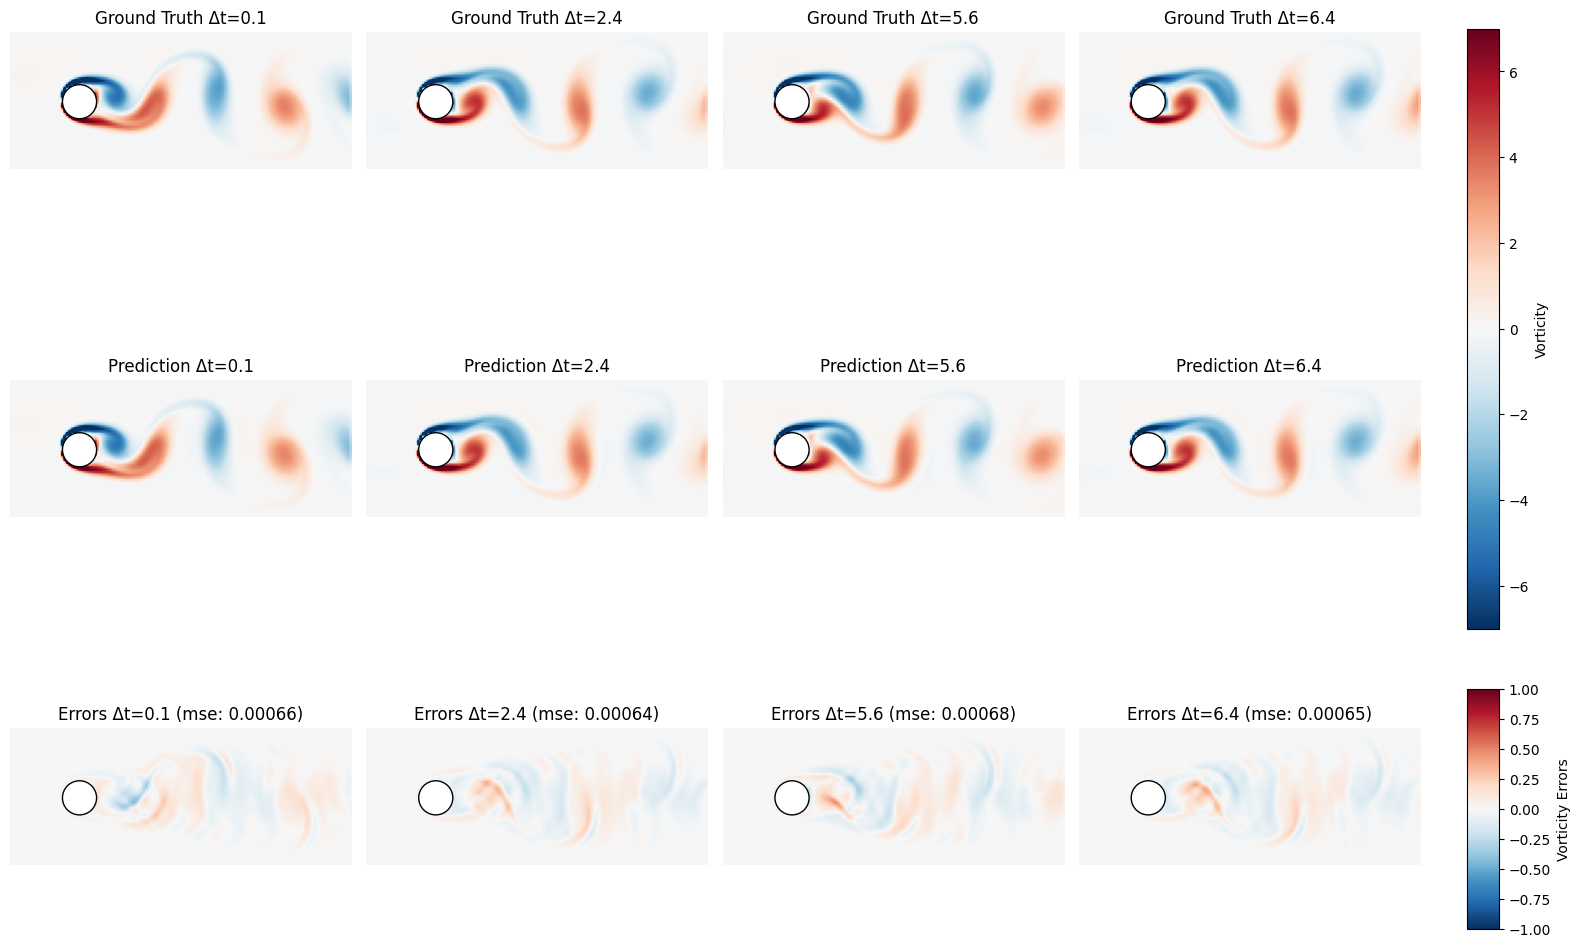

Visualization saved as 'vorticity_predictions.png'


In [ ]:
# @title Vorticity Field Visualization Script
"""
Vorticity Field Visualization Script
==================================

Creates a comparison plot showing ground truth, predictions, and errors
for vorticity fields at different time steps.
"""

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def generate_predictions(model, test_data, num_samples=4, time_indices=None):
    """Generate predictions for specific snapshots from test data."""
    # Get test batch
    inputs, targets = next(iter(test_data))

    # Default time indices if none provided
    if time_indices is None:
        time_indices = tf.constant([0, 15, 47, 63])

    # Generate predictions
    predictions_ = []
    for i in time_indices:
        snapshot = model(inputs[i:i+1], training=False)
        predictions_.append(snapshot[:, -1, :])

    predictions = tf.stack(predictions_, axis=0)
    ground_truth = tf.gather(targets[:, -1, :], time_indices)

    return predictions, ground_truth

def create_vorticity_plot(predictions, ground_truth, shape_params, plot_params):
    """Create comparison plot of vorticity fields."""
    # Unpack parameters
    ny, nx = shape_params['ny'], shape_params['nx']
    cx, cy, r = shape_params['cx'], shape_params['cy'], shape_params['r']
    dx, dy = shape_params['dx'], shape_params['dy']
    dt = shape_params['dt']

    # Reshape data
    pred_reshape = predictions.numpy().reshape(-1, ny, nx)
    truth_reshape = ground_truth.numpy().reshape(-1, ny, nx)

    # Create plot
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))

    # Plot parameters
    vmin, vmax = -7, 7
    error_lim = 1.0

    for i in range(4):
        time = (1.0 + plot_params['time_indices'][i].numpy()) * dt

        # Plot ground truth
        im0 = axes[0, i].imshow(truth_reshape[i], vmin=vmin, vmax=vmax, cmap='RdBu_r')
        axes[0, i].set_title(f'Ground Truth Δt={time:.1f}')
        axes[0, i].axis('off')

        # Plot prediction
        im1 = axes[1, i].imshow(pred_reshape[i], vmin=vmin, vmax=vmax, cmap='RdBu_r')
        axes[1, i].set_title(f'Prediction Δt={time:.1f}')
        axes[1, i].axis('off')

        # Plot error
        diff = truth_reshape[i] - pred_reshape[i]
        mse = np.linalg.norm(diff)/(nx*ny)
        #mse= np.linalg.norm(diff)/np.linalg.norm(truth_reshape[i]) # RELATIVE l2
        im2 = axes[2, i].imshow(diff, cmap='RdBu_r', vmax=error_lim, vmin=-error_lim)
        axes[2, i].set_title(f'Errors Δt={time:.1f} (mse: {mse:.5f})')
        axes[2, i].axis('off')

        # Add cylinder to all plots
        for ax in [axes[0, i], axes[1, i], axes[2, i]]:
            circle = plt.Circle((cx/dx, cy/dy), r/dx,
                              facecolor='white', edgecolor='black', linewidth=1.0)
            ax.add_artist(circle)

    # Add colorbars
    cbar_ax = fig.add_axes([0.92, 0.35, 0.02, 0.5])
    cbar = fig.colorbar(im0, cax=cbar_ax)
    cbar.set_label('Vorticity')

    cbar_ax2 = fig.add_axes([0.92, 0.1, 0.02, 0.2])
    cbar2 = fig.colorbar(im2, cax=cbar_ax2)
    cbar2.set_label('Vorticity Errors')

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    return fig

# Main execution
if __name__ == "__main__":
    # Define time indices for visualization
    time_indices = tf.constant([0, 23, 55, 63])

    # Generate predictions
    predictions, ground_truth = generate_predictions(
        model=model_fm,
        test_data=test_data,
        time_indices=time_indices
    )

    # Set up parameters for plotting
    shape_params = {
        'ny': data.shape[1],
        'nx': data.shape[2],
        'cx': lx / 5.0,
        'cy': ly / 2.0,
        'r': 0.5,
        'dx': dx,
        'dy': dy,
        'dt': dt
    }

    plot_params = {
        'time_indices': time_indices
    }

    # Create and save plot
    fig = create_vorticity_plot(predictions, ground_truth, shape_params, plot_params)
    fig.savefig('vorticity_predictions.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    print("Visualization saved as 'vorticity_predictions.png'")

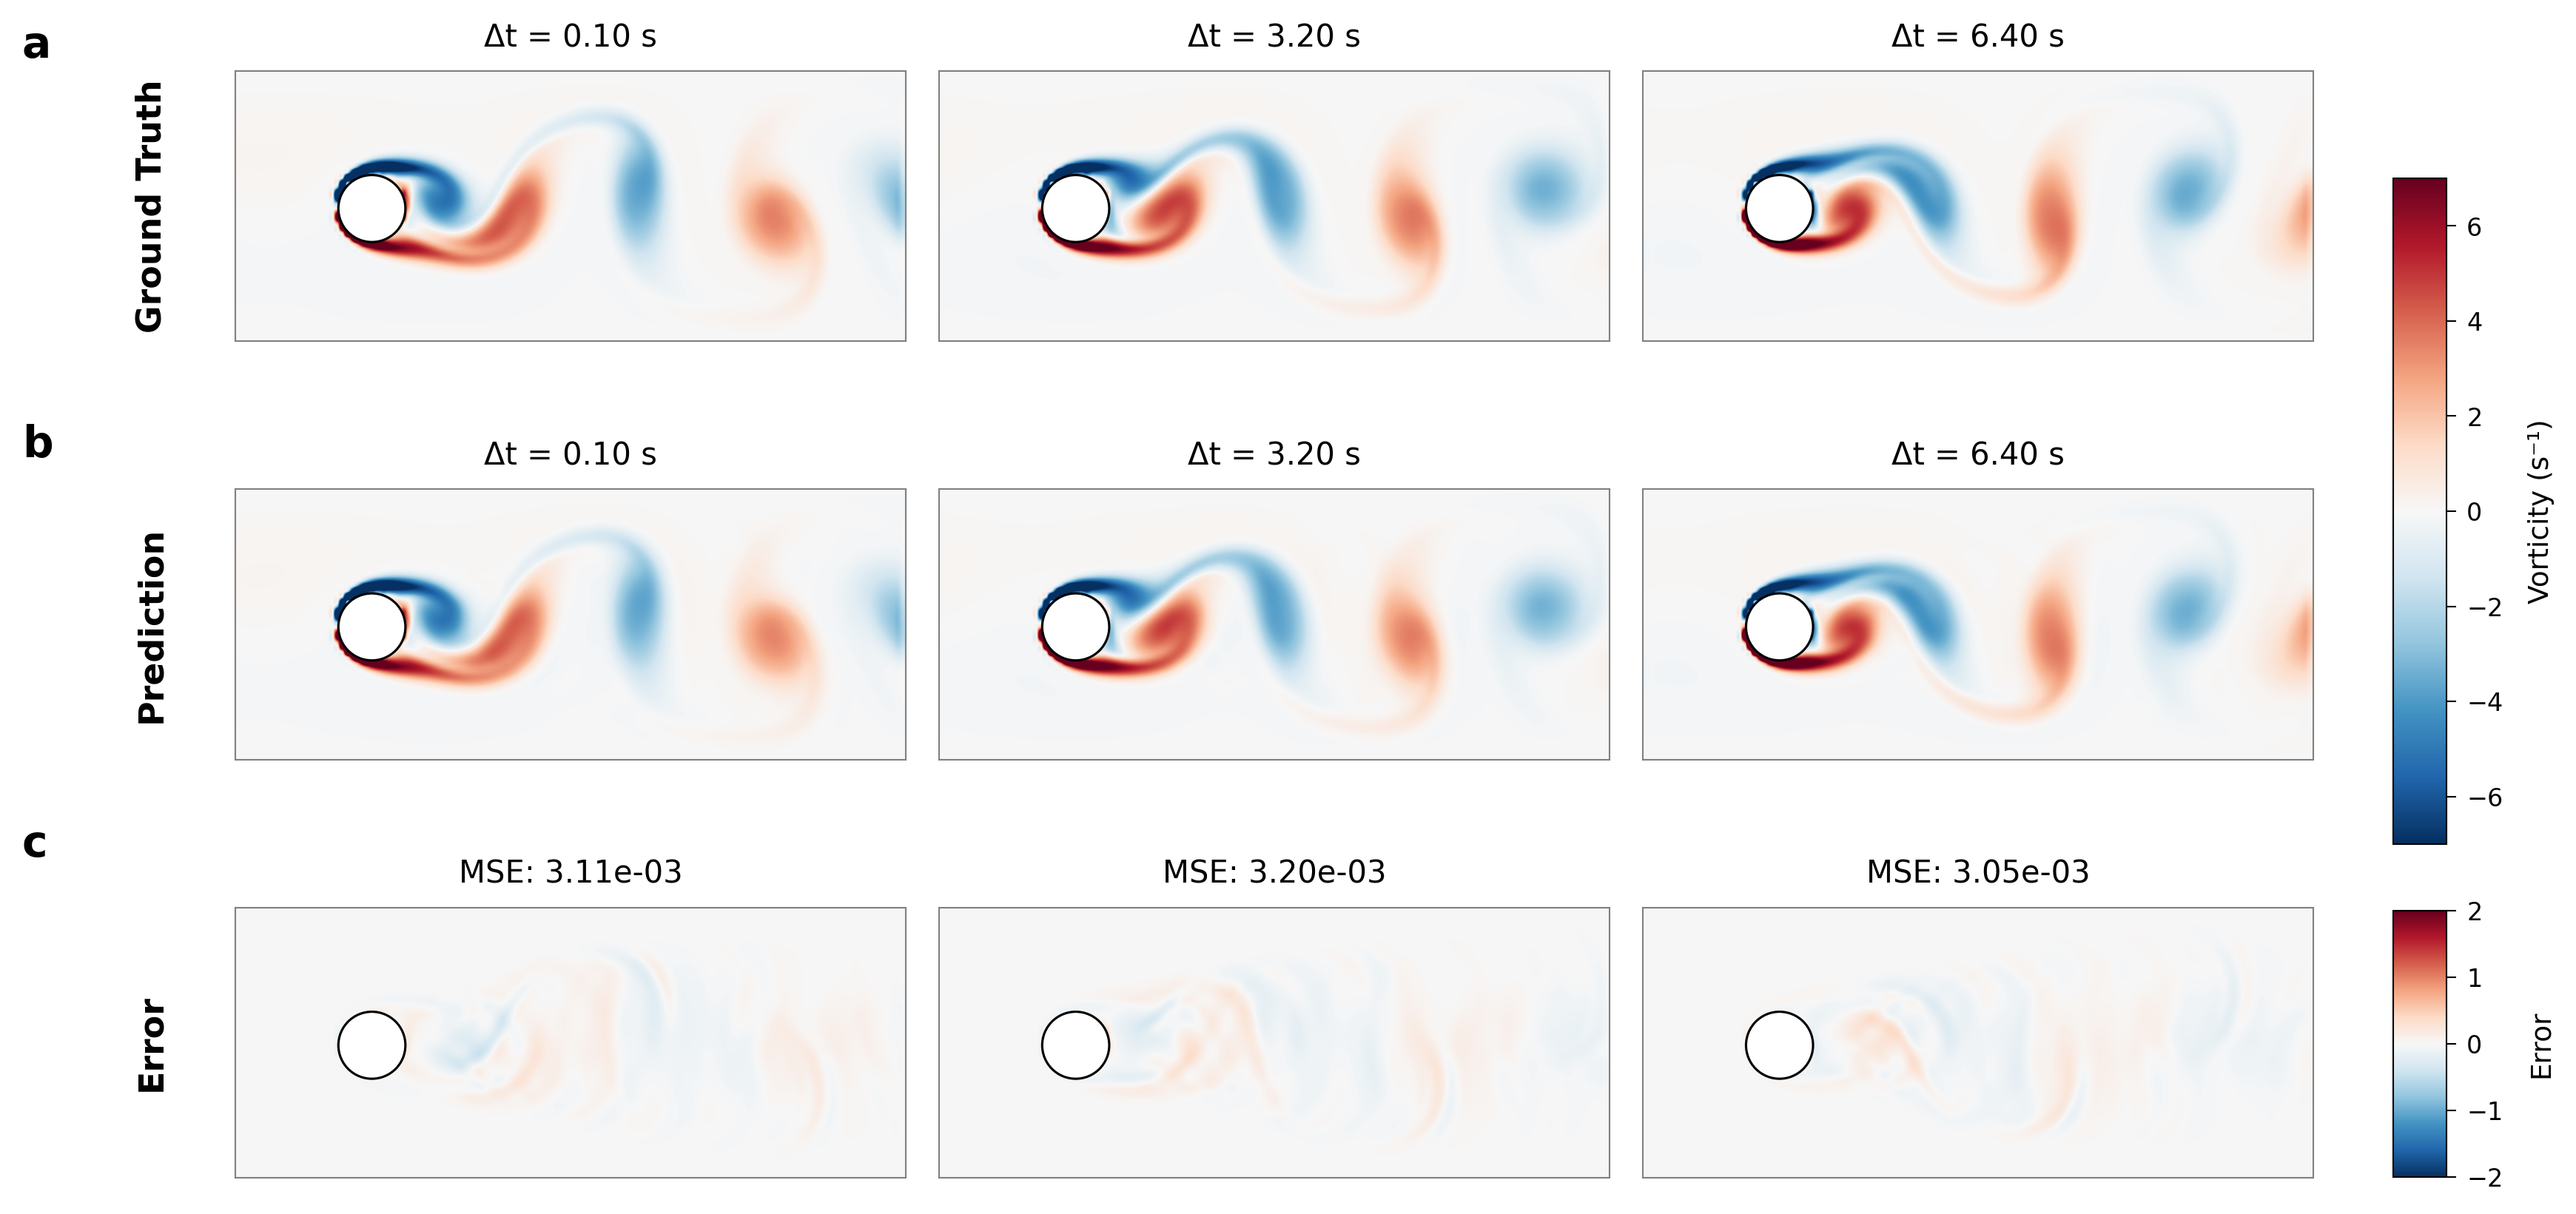

High-quality visualization saved as 'vorticity_predictions.pdf'


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import rcParams

def set_nature_style():
    """Set publication-quality plotting style."""
    plt.style.use('default')
    rcParams['axes.labelsize'] = 9
    rcParams['xtick.labelsize'] = 8
    rcParams['ytick.labelsize'] = 8
    rcParams['axes.linewidth'] = 0.5
    rcParams['grid.linewidth'] = 0.5
    rcParams['lines.linewidth'] = 1.0
    rcParams['figure.dpi'] = 300

def create_vorticity_plot(predictions, ground_truth, shape_params, plot_params):
    """Create publication-quality comparison plot of vorticity fields."""
    # Set style
    set_nature_style()

    # Unpack parameters
    ny, nx = shape_params['ny'], shape_params['nx']
    cx, cy, r = shape_params['cx'], shape_params['cy'], shape_params['r']
    dx, dy = shape_params['dx'], shape_params['dy']
    dt = shape_params['dt']

    # Reshape data
    pred_reshape = predictions.numpy().reshape(-1, ny, nx)
    truth_reshape = ground_truth.numpy().reshape(-1, ny, nx)

    # Create figure
    fig = plt.figure(figsize=(12, 6))
    gs = plt.GridSpec(3, 3, figure=fig,
                     hspace=0.3, wspace=0.05,
                     left=0.1, right=0.88,
                     top=0.95, bottom=0.08)

    # Plot parameters
    vmin, vmax = -7, 7
    error_lim = 2.0

    # Row labels with larger font and bold
    row_labels = ['Ground Truth', 'Prediction', 'Error']

    axes = [[fig.add_subplot(gs[i, j]) for j in range(3)] for i in range(3)]

    for i in range(3):
        time = (1.0 + plot_params['time_indices'][i].numpy()) * dt

        # Common imshow parameters
        imshow_params = {
            'cmap': 'RdBu_r',
            'aspect': 'equal',
            'interpolation': 'spline16'  # Smoother interpolation
        }

        # Plot ground truth
        im0 = axes[0][i].imshow(truth_reshape[i], vmin=vmin, vmax=vmax, **imshow_params)
        if i == 0:
            axes[0][i].text(-0.15, 0.5, row_labels[0],
                          transform=axes[0][i].transAxes,
                          rotation=90, va='center', fontsize=11, fontweight='bold')

        # Plot prediction
        im1 = axes[1][i].imshow(pred_reshape[i], vmin=vmin, vmax=vmax, **imshow_params)
        if i == 0:
            axes[1][i].text(-0.15, 0.5, row_labels[1],
                          transform=axes[1][i].transAxes,
                          rotation=90, va='center', fontsize=11, fontweight='bold')

        # Plot error
        diff = truth_reshape[i] - pred_reshape[i]
        mse = np.mean(diff**2)
        relative_l2 = np.sqrt(np.mean(diff**2)/np.mean(truth_reshape[i]**2))
        im2 = axes[2][i].imshow(diff, vmax=error_lim, vmin=-error_lim, **imshow_params)
        if i == 0:
            axes[2][i].text(-0.15, 0.5, row_labels[2],
                          transform=axes[2][i].transAxes,
                          rotation=90, va='center', fontsize=11, fontweight='bold')

        # Add time labels to both first and second rows
        for row in [0, 1]:
            axes[row][i].set_title(f'Δt = {time:.2f} s', pad=8, fontsize=10)

        # Add MSE values
        axes[2][i].set_title(f'MSE: {mse:.2e}', pad=8, fontsize=10)

        # Add cylinder and style each subplot
        for ax in [axes[0][i], axes[1][i], axes[2][i]]:
            # Remove axes
            ax.set_xticks([])
            ax.set_yticks([])

            # Add cylinder
            circle = plt.Circle((cx/dx, cy/dy), r/dx,
                              facecolor='white', edgecolor='black',
                              linewidth=0.75, clip_on=False)
            ax.add_artist(circle)

            # Set background color
            ax.set_facecolor('#f8f8f8')

            # Add thin border
            for spine in ax.spines.values():
                spine.set_linewidth(0.5)
                spine.set_color('gray')

    # Add colorbars with refined styling
    cbar_ax = fig.add_axes([0.91, 0.35, 0.02, 0.5])
    cbar = fig.colorbar(im0, cax=cbar_ax)
    cbar.set_label('Vorticity (s⁻¹)', fontsize=9, labelpad=8)
    cbar.ax.tick_params(labelsize=8, length=3, width=0.5)
    cbar.outline.set_linewidth(0.5)

    cbar_ax2 = fig.add_axes([0.91, 0.1, 0.02, 0.2])
    cbar2 = fig.colorbar(im2, cax=cbar_ax2)
    cbar2.set_label('Error', fontsize=9, labelpad=8)
    cbar2.ax.tick_params(labelsize=8, length=3, width=0.5)
    cbar2.outline.set_linewidth(0.5)

    # Add subplot labels - moved closer to figures
    label_params = {'fontsize': 14, 'fontweight': 'bold', 'va': 'center'}
    fig.text(0.02, 0.95, 'a', **label_params)
    fig.text(0.02, 0.65, 'b', **label_params)
    fig.text(0.02, 0.35, 'c', **label_params)

    return fig

# Main execution
if __name__ == "__main__":
    # Define time indices for visualization
    time_indices = tf.constant([0, 31, 63])

    # Generate predictions
    predictions, ground_truth = generate_predictions(
        model=model_fm,
        test_data=test_data,
        time_indices=time_indices
    )

    # Set up parameters for plotting
    shape_params = {
        'ny': data.shape[1],
        'nx': data.shape[2],
        'cx': lx / 5.0,
        'cy': ly / 2.0,
        'r': 0.5,
        'dx': dx,
        'dy': dy,
        'dt': dt
    }

    plot_params = {
        'time_indices': time_indices
    }

    # Create and save plot
    fig = create_vorticity_plot(predictions, ground_truth, shape_params, plot_params)

    # Save with high quality settings
    fig.savefig('vorticity_predictions.pdf',
                dpi=300,
                bbox_inches='tight',
                facecolor='white',
                edgecolor='none',
                metadata={'Creator': 'Matplotlib',
                         'Title': 'Vorticity Prediction Analysis'})

    plt.show()
    plt.close()

    print("High-quality visualization saved as 'vorticity_predictions.pdf'")